##ID: 99905
## MBD_Módulo 5: 
## Churn Prediction

En éste Notebook, desarrollaremos un modelo para predecir el Churn de clientes a partir del DataSet publicado en Kaggle (WA_Fn-UseC_-Telco-Customer-Churn.csv).

Una vez registrados en Kaggle, descargaremos el fichero telco-customer-churn.zip y lo subiremos al entorno para poder acceder a él.

El proyecto requiere de dos ficheros adicionales:

*   **features_binary.json**
*   **features_label.json**

Corresponde a las features seleccionadas habiendo codificado el DataSet usando LabelEncoding y One Hot Encoding, respectivamente.


## Entendiendo las variables
Echaremos un primer vistazo a las variables (usando MS Excel) y partiendo de la documentación de Kaggle, comenzaremos con una primera interpretación de las variables:
* **CustomerID**. Customer ID. Para el modelado, es una variable a descartar.
* **gender**. Si el cliente es Male o Female.
* **SeniorCitizen**. Si el cliente es “senior citizen” o no (1, 0)
* **Partner**. Si el cliente tiene un distribuidor o no (Yes, No)
* **Dependents**. Si el cliente tiene “dependents” (Yes, No)
* **tenure**. Número de meses que el cliente lleva en la empresa.
* **PhoneService**. Si tiene servicio telefónico o no  (Yes, No)
* **MultipleLines**. Si tiene múltiples líneas o no (Yes, No, No phone service). Si PhoneService es “No”, MultipleLines es “No phone service”. Quizás, no sea necesario distinguir por éste último valor, por lo que se podría transformar a Yes/No.
* **InternetService**. Servicio de datos  (DSL, Fiber optic, No)
* **OnlineSecurity**. Si tiene servicio añadido “OnlineSecurity” (Yes, No, No internet service). Si InternetService es “No”, OnlineSecurity es “No internet service”. Quizás, no sea necesario distinguir por éste último valor, por lo que se podría transformar a Yes/No.
* **OnlineBackup**. Si tiene servicio añadido “OnlineBackup” (Yes, No, No internet service). Si InternetService es “No”, OnlineBackup es “No internet service”. Quizás, no sea necesario distinguir por éste último valor, por lo que se podría transformar a Yes/No.
* **DeviceProtection**. Si tiene servicio añadido “DeviceProtection” (Yes, No, No internet service). Si InternetService es “No”, DeviceProtection es “No internet service”. Quizás, no sea necesario distinguir por éste último valor, por lo que se podría transformar a Yes/No.
* **TechSupport**. Si tiene servicio añadido “TechSupport” (Yes, No, No internet service). Si InternetService es “No”, TechSupport es “No internet service”. Quizás, no sea necesario distinguir por éste último valor, por lo que se podría transformar a Yes/No.
* **StreamingTV**. Si tiene servicio añadido “StreamingTV” (Yes, No, No internet service). Si InternetService es “No”, StreamingTV es “No internet service”. Quizás, no sea necesario distinguir por éste último valor, por lo que se podría transformar a Yes/No.
* **StreamingMovies**. Si tiene servicio añadido “StreamingMovies” (Yes, No, No internet service). Si InternetService es “No”, StreamingMovi es “No internet service”. Quizás, no sea necesario distinguir por éste último valor, por lo que se podría transformar a Yes/No.
* **Contract**. Tipo de contrato (Month-to-month, One year, Two year).
* **PaperlessBilling**. Si el cliente tiene Factura electrónica (Yes, No).
* **PaymentMethod**. Método de pago (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* **MonthlyCharges**. Cuota mensual (no queda claro si corresponde a valores medios).
* **TotalCharges**. Total cantidad facturada. 
* **Churn**. Variable objetivo. Indica que el cliente se ha dado de baja (Yes or No)


Es curioso que no existan variables asociadas a iteraciones del cliente con la compañía (Incidencias, Llamadas al CallCenter, etc..) así como uso de los distintos servicios contratados (llamadas de voz, megas consumidos, películas vistas, etc..)

Si la variable **tenure** indica los meses que el cliente lleva en la compañía, se podría plantear que existe una relación entre **TotalCharges** y **MonthlyCharges**, de tal manera que: **TotalCharges=tenure·MonthlyCharges**. En aquellos casos que no coincida, y suponiendo que MonthlyCharges es la cuota mensual actual y no la media de las cuotas, un valor distinto de cero en ésta variable podría suponer bien cargos extras o abonos (conceptos ajenos a la cuota del servicio) bien cambio de servicio que hacen que la cuota cambie. Si fuera el caso, sería interesante categorizar aquellos que han cambiado a contratar mayores servicios (**up selling/cross selling**) o todo lo contrario. Crearemos la variable **DiffCarges** como diferencia de la cuota media (**TotalCharges/tenure**) y la cuota mensula (**MonthlyCharges**).


## Funciones Auxiliares

In [2]:
!pip install jenkspy

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import jenkspy
import numpy as np
import json
import warnings

warnings.filterwarnings("ignore")

from sklearn.feature_selection import RFECV
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, recall_score, fbeta_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Funciones para Graficar

In [0]:
'''
  Función para graficar histograma.
    params => 
      df (DataFrame)
      var (variable a pintar)
      breaks (si existen puntos de corte. Binarización de variables numéricas)
      En caso que existan, pintará una línea vertical.
'''
def histogramChar(df, var, breaks):
  fig, ax = plt.subplots(1, 2, figsize=(14, 4))
  df[var].hist(bins=100, color="green", alpha=0.5, ax=ax[0], label=var).set_title(var)
  df[df['Churn'] == "No"][var].hist(bins=100, color="blue", alpha=0.5, ax=ax[1], label="Churn No").set_title(var)
  df[df['Churn'] == "Yes"][var].hist(bins=100, color="red", alpha=0.5, ax=ax[1], label="Churn Yes").set_title(var)
  if breaks:
    for break_jenk in breaks:
      ax[0].axvline(break_jenk, color='k', linestyle='dashed', linewidth=1)
      ax[1].axvline(break_jenk, color='k', linestyle='dashed', linewidth=1)
  plt.legend()
  plt.show()  

'''
  Función para graficar un pie char.
    params => 
      df (DataFrame)
      var (variable a pintar)
      pies 
        (si se quiere graficar la relación de la variable var con la variable target <=> churn)
        (si se quiere graficar la relación de target con la variable var <=> var)
'''
def pieChar(df, var, pies):
  dfUniq = df[var].unique()
  

  #fig.patch.set_facecolor('#0F0F0F')
  #fig.patch.set_facecolo<r('xkcd:aqua')  

  if 'churn' in pies:
    fig, axes = plt.subplots(1, 3, figsize=(12,5))
    fig.suptitle('Distribucion por variable "' + var + '"')
    data = [
        {'data': df[var].value_counts().sort_index(), 'title': 'Completa'},
        {'data': df[df['Churn'] == "No"][var].value_counts().sort_index(), 'title': 'Churn No'},
        {'data': df[df['Churn'] == "Yes"][var].value_counts().sort_index(), 'title': 'Churn Yes'}
    ]
    for i in range(3):
      explode = [0 for x in range(data[i]['data'].shape[0]-1)] + [0.1]
      wedges, texts, autotexts = axes[i].pie(data[i]['data'],
        autopct=lambda p : '{:.2f}%\n({:.0f})'.format(p, p*data[i]['data'].sum()/100),                                           
        explode=explode,
        startangle=90,
        colors=colors,
        shadow=True,
        textprops=dict(color="w"))
      if i==2:
        axes[i].legend(wedges, data[i]['data'].index,
          title='',
          loc='center left',
          bbox_to_anchor=(0.984, 1.55),
          fancybox=True, shadow=True)

      plt.setp(autotexts, size=8, weight="bold")

      axes[i].set_title(data[i]['title'])
      axes[i].set_ylabel('')
  if 'var' in pies:  
    i = 1
    fig, axes = plt.subplots(1, dfUniq.shape[0]+1, figsize=(12,5))
    if not 'churn' in pies:
      fig.suptitle('Distribucion por variable "' + var + '"') 
    #fig.patch.set_facecolor('#0F0F0F')
    #fig.patch.set_facecolor('xkcd:aqua')
    df['Churn'].value_counts().sort_index().plot('pie', ax=axes[0], explode=[0, 0.1], 
      autopct=lambda p : '{:.2f}%\n({:.0f})'.format(p, p*sum(df['Churn'].value_counts())/100), 
      shadow=True, startangle=45, colors=colors).set_title('Completa') 

    for value in dfUniq:
      title = str(value)
      title = title if len(title)>3 else var + ':' + title
      dfFilter = df[df[var]==value]['Churn'].value_counts().sort_index()
      dfFilter.plot('pie', 
          ax=axes[i], explode=[0 for x in range(dfFilter.value_counts().shape[0]-1)] + [0.1], 
          autopct=lambda p : '{:.2f}%\n({:.0f})'.format(p, p*sum(dfFilter)/100), 
          shadow=True, startangle=45, 
          colors=colors).set_title(title)  
      i+=1

  
  plt.show()
  
'''
  Función copia-pega para graficar la matriz de confusión.
    params => 
      params (array de métricas de salida del modelo incluido los valores y_true e y_test)
      y_pred (vector predicho)
      normalize (Si se quieren valores absolutos o porcentuales)
      title (Título del gráfico)
'''
def paintConfusionMatrix(params, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    classes = ['Churn No', 'Churn Yes']
    y_true = []
    y_pred = []
    for param in params:
      y_true+= param['y_true'].tolist()
      y_pred+= param['y_pred'].tolist()
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+cm.sum(axis=0)[:, np.newaxis])

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    
'''
  Función copia-pega para graficar la curva ROC a partir de 
  varios subsets (Fold) dados por Cross Validation.
    params => 
      X, y: variable de entrenamiento y variable target.
      algorithm: instancia del modelo a usar.
      title (Título del gráfico)
      sampler (objeto asociad a la técnica de oversampling o undersampling)
    return =>
      
'''
def paintROCCurve(X, y, algorithm, title, sampler=None):

  from scipy import interp
  import datetime
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  cv = StratifiedKFold(n_splits=10)
  i = 0
  results = []
  for train, test in cv.split(X, y):
      ini_timestamp = float(datetime.datetime.now().strftime("%s.%f"))
      if sampler:                
        X_train, y_train = sampler.fit_sample(X.iloc[train], y.iloc[train].values.ravel())
        X_train = pd.DataFrame(data = X_train, columns=X.iloc[train].columns)
      else:
        X_train = X.iloc[train]
        y_train = y.iloc[train].values.ravel()

      X_test = X.iloc[test]
      y_test = y.iloc[test].values.ravel()

      algorithm.fit(X_train, y_train)
      
      probas_ = algorithm.predict_proba(X_test)
      
      y_pred_test = algorithm.predict(X_test)
      y_pred_train = algorithm.predict(X_train)


      f1_train = f1_score(y_train, y_pred_train)
      f1_test = f1_score(y_test, y_pred_test)
      #print(i, "accuracy:", accuracy, "recall: ", recall)
      # Compute ROC curve and area the curve
      fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      tprs[-1][0] = 0.0
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      results.append({
          'f1_train': f1_train,
          'f1_test': f1_test,
          'roc_auc': roc_auc,
          'y_pred': y_pred_test,
          'y_true': y_test,
          'duration': float(datetime.datetime.now().strftime("%s.%f")) - ini_timestamp
      })
      plt.plot(fpr, tpr, lw=1, alpha=0.3,
               label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))

      i += 1
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
           label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  plt.plot(mean_fpr, mean_tpr, color='b',
           label=r'Mean ROC (AUC = %0.4f $\pm$ %0.2f)' % (mean_auc, std_auc),
           lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                   label=r'$\pm$ 1 std. dev.')

  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()
  return results

'''
  Función para pintar la curva de total de variables seleccionadas 
  y la métrica con la que se optimiza.
    params => 
      scoring: Contiene el scoring para cada número de variables 
        así como valores máximos.
      algorithm_name: Modelo usado.
'''
def paintFeaturesSelection(scorings, algorithm_name):
  # Plot number of features VS. cross-validation scores
  fig, ax = plt.subplots(1, len(scorings), figsize=(14, 4))
  i = 0
  for key in scorings:
    scoring = scorings[key]
    
    ax[i].set_xlabel("Número de Variables")
    ax[i].set_ylabel("Cross validation score (" + key + ")")
    ax[i].set_title("Modelo " + algorithm_name + " (" + key + ")")

    ax[i].plot(range(1, len(scoring['scores']) + 1), [k for k in scoring['scores']], label=key)
    ax[i].axhline(scoring['max_score'], color='k', linestyle='dashed', linewidth=1)
    ax[i].axvline(scoring['num_features'], color='k', linestyle='dashed', linewidth=1)
    i+= 1
  plt.show()  
  
'''
  Función para pintar todas las curvas de total de variables seleccionadas 
  de todos los modelos.
    params => 
      models_label: Contiene el scoring para todos los modelos
'''
def paintFeaturesSelectionModels(models_label):
  # Plot number of features VS. cross-validation scores
  fig, ax = plt.subplots(1, 2, figsize=(14, 4))
  for name, scorings in models_label_features.items():
    i = 0
    for key in scorings:
      scoring = scorings[key]

      ax[i].set_xlabel("Número de Variables")
      ax[i].set_ylabel("Cross validation score (" + key + ")")
      ax[i].set_title("Modelo (" + key + ")")

      ax[i].plot(range(1, len(scoring['scores']) + 1), [k for k in scoring['scores']], label=name)
      ax[i].legend(loc="bottom right")
      #ax[i].axhline(scoring['max_score'], color='k', linestyle='dashed', linewidth=1)
      #ax[i].axvline(scoring['num_features'], color='k', linestyle='dashed', linewidth=1)
      i+= 1
  plt.show()    


### Funciones de Tratamiento

In [0]:
'''
  Función para calcular el precio teórico a partir de los servicios.
    params => 
      row (regristro a calcular)
'''
def getTheoricalMonthlyCharge(row):
  price = 0
  if row['PhoneService']=='Yes':
    price+=20
  if row['MultipleLines']=='Yes':
    price+=5
  if row['InternetService']=='DSL':
    price+=25
  if row['InternetService']=='Fiber optic':
    price+=70-20
  if row['OnlineSecurity']=='Yes':
    price+=5
  if row['OnlineBackup']=='Yes':
    price+=5
  if row['DeviceProtection']=='Yes':
    price+=5
  if row['TechSupport']=='Yes':
    price+=5
  if row['StreamingTV']=='Yes':
    price+=5
  if row['StreamingMovies']=='Yes':
    price+=5
  return price

'''
  Función copia-pega para sacar la discretización de las variables numéricas
  basado en el algoritmo de Jenkspy.
'''
def goodness_of_variance_fit(list_of_values, nb_class):
  list_of_values, nb_class
  
  def classify(value, breaks):
    for i in range(1, len(breaks)):
      if value < breaks[i]:
        return i
    return len(breaks) - 1
  
  # get the break points
  classes = jenkspy.jenks_breaks(list_of_values, nb_class)

  # do the actual classification
  classified = np.array([classify(i, classes) for i in list_of_values])
  # max value of zones
  maxz = max(classified)

  # nested list of zone indices
  zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

  # sum of squared deviations from array mean
  sdam = np.sum((list_of_values - list_of_values.mean()) ** 2)

  # sorted polygon stats
  list_of_values_sort = [np.array([list_of_values[index] for index in zone]) for zone in zone_indices]

  # sum of squared deviations of class means
  sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in list_of_values_sort])

  # goodness of variance fit
  gvf = (sdam - sdcm) / sdam

  return gvf, classified, classes


##### Funciones extras para calcular WOE e Information Value (IV)

#https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb
#https://github.com/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb

'''
https://pypi.org/project/woe/
https://pypi.org/project/woe-iv/
'''
  
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

force_bin = 3

# define a binning function
def mono_bin(Y, X, n = 30):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)
  

'''
  Función que Calcula y devuelve el conjunto potencia de la lista c.
'''
def combinatoria(c):
  if len(c) == 0:
    return [[]]
  r = combinatoria(c[:-1]) 
  r = r + [s + [c[-1]] for s in r]
  return [e for e in sorted(r, key=lambda s: (len(s), s))]

'''
  Funcion que genera un dataframe a partir de las métricas de salida
  de los modelos ML
    params => 
      params (parámetros de salida del modelo: fbeta_score, roc_auc,..)
      model (nombre del modelo)
'''
def createParamsDataFrame(params, model, dataset, variables, sampler):
  y_true = []
  y_pred = []
  for param in params:
    y_true+= param['y_true'].tolist()
    y_pred+= param['y_pred'].tolist()
    # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+cm.sum(axis=0)[:, np.newaxis])

  dfParamsAux = pd.DataFrame(params)
  dfParamsAux = dfParamsAux.drop(['y_pred', 'y_true'], axis=1)
  dfParamsAux['model'] = model
  dfParamsAux['dataset'] = dataset
  dfParamsAux['variables'] = variables
  dfParamsAux['sampler'] = sampler
  dfParamsAux['cv'] = dfParamsAux.index
  dfParamsAux['TN'] = cm[0,0]  
  dfParamsAux['FP'] = cm[0,1]
  dfParamsAux['FN'] = cm[1,0]  
  dfParamsAux['TP'] = cm[1,1]
  return dfParamsAux

'''
  Función copia-pega de RFECV para calcular las mejores features del Dataset.
  Se ha adaptado para usar SFS con Cross Validation
    params => 
      X, y: variable de entrenamiento y variable target.
      algorithm: instancia del modelo a usar.
      scorings: las metricas a usar para optimizar el modelo
    return => JSON para cada métrica con las features seleccionadas
      así como valores medios para cada número de features seleccionadas
'''
def selectFeatures(X, y, algorithm, algorithm_name, scorings):
  cv = StratifiedKFold(n_splits=10)
  i = 0
  
  results = {}
  for scoring in scorings:
    if algorithm_name not in ['KNN', 'NB']:
      selector = RFECV(algorithm, step=1, cv=cv, n_jobs=-1, scoring=scoring)
      selector = selector.fit(X, y.values.ravel())
      num_features = int(selector.n_features_)
      features = [f for f,s in zip(X.columns, selector.support_) if s]
      max_score = -1.0
      scores = []
      for k in selector.grid_scores_:
        scores.append(k)
        if k>max_score:
          max_score = k
    else:
      selector = SFS(algorithm, 
			   k_features=len(X.columns), 
			   forward=True, 
			   floating=False, 
			   verbose=0,
			   scoring=scoring,
			   n_jobs=-1,
			   cv=cv)
      selector = selector.fit(X, y.values.ravel(), custom_feature_names=X.columns) 
      scores = []
      max_score = -1.0
      num_features = 0
      for key in selector.subsets_:
        subset = selector.subsets_[key]
        if subset['avg_score']>max_score:
          max_score = subset['avg_score']
          num_features = int(key)
        scores.append(subset['avg_score'])
      features = sorted(selector.subsets_[num_features]['feature_names'])

    features_out = sorted(list(set(X.columns.tolist()) - set(features)))
    print(algorithm_name)
    print("Número óptimo de variables (" + scoring + ") : %d de %d" % (num_features, X.shape[1]))
    print('variables seleccionadas:')
    print ('{}'.format(features))
    print('variables eliminadas:')
    print ('{}'.format(features_out))
		
    results[scoring] = {
      'in': features,
      'out': features_out,
      'scores': scores,
      'max_score': max_score,
      'num_features': num_features
    }
    i+= 1

  return results 


## Carga del DataSet

El método describe de Pandas nos da mucha información. Es curioso que indique que no hay valores null en todos los registros, sin embargo, la variable **TotalCharges** tiene valores vacíos justo cuando el valor de **tenure** es 0. Podemos hacer que su valor sea el correspondiente a **MonthlyCharges**. De ésta manera, aseguramos que no existen campos vacios.

In [5]:
input_file = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
separator = ","
decimal = "."
dfChurn = pd.read_csv(filepath_or_buffer=input_file, sep=separator, decimal=decimal)
#Actualización de TotalCharges a MonthlyCharges si tenure = 0
dfChurn['TotalCharges'] = pd.np.where(
    dfChurn['tenure']==0, 
    dfChurn['MonthlyCharges'], 
    dfChurn['TotalCharges']
)
dfChurn['TotalCharges'] = dfChurn['TotalCharges'].astype(float)
#Modificación de 0/1 a No/Yes
dfChurn['SeniorCitizen'] = pd.np.where(
    dfChurn['SeniorCitizen']==0, 
    'No', 
    'Yes'
)
#Cálculo de diferencia de coste.
dfChurn['DiffCharges'] = pd.np.where(dfChurn['tenure']==0, 0.0, 
  (dfChurn['TotalCharges']/dfChurn['tenure'] - dfChurn['MonthlyCharges']).round(decimals=4)
)
#Transformamos texto para mejorar presentacion
for col in dfChurn.select_dtypes(include='object'):
  dfChurn[col] = dfChurn[col].str.replace("(automatic)", "", regex=False)
  dfChurn[col] = dfChurn[col].str.replace("No phone service", "No service", regex=False)
  dfChurn[col] = dfChurn[col].str.replace("No internet service", "No service", regex=False)

#Creamos la variable objetivo en numerica 1 <=> Yes, 0 <=> No  
dfChurn['target'] = dfChurn['Churn'].apply(lambda x : 1 if x == 'Yes' else 0)

dfChurn.head()


customerID  gender SeniorCitizen  ... Churn DiffCharges  target
0  7590-VHVEG  Female            No  ...    No      0.0000       0
1  5575-GNVDE    Male            No  ...    No     -1.3765       0
2  3668-QPYBK    Male            No  ...   Yes      0.2250       1
3  7795-CFOCW    Male            No  ...    No     -1.3944       0
4  9237-HQITU  Female            No  ...   Yes      5.1250       1

[5 rows x 23 columns]

In [7]:
dfChurn.describe()


tenure  MonthlyCharges  TotalCharges  DiffCharges       target
count  7043.000000     7043.000000   7043.000000  7043.000000  7043.000000
mean     32.371149       64.761692   2279.798992     0.001214     0.265370
std      24.559481       30.090047   2266.730170     2.614121     0.441561
min       0.000000       18.250000     18.800000   -19.125000     0.000000
25%       9.000000       35.500000    398.550000    -1.145550     0.000000
50%      29.000000       70.350000   1394.550000     0.000000     0.000000
75%      55.000000       89.850000   3786.600000     1.159100     1.000000
max      72.000000      118.750000   8684.800000    18.900000     1.000000

In [8]:
dfChurn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null object
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null object
DiffCharges         7043 non-nu

## Análisis Exploratorio
Distinguiremos entre las variables numéricas y las categóricas y veremos cómo de balanceado está el dataset con respecto a la variable objetivo **churn**.

En el proyecto grupal, se trabajó con la librería **Plotly**. En éste, por motivos didácticos, se utilizará la librería **matplotlib** + **seborn**. 


###Relación de Servicios

Parece interesante "descubrir" el precio unitario de los distintos servicios contratados: Voz, DSL, Fibra, así como servicios de valor añadido: Multiple Lines, Streaming, etc.. Haremos un agrupamiento por todos ellos y nos centraremos en la variable **MonthlyCost**.

In [9]:
dfServices = dfChurn.groupby(['PhoneService',
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'])['MonthlyCharges'].mean().reset_index()
#dfServices.loc[(dfServices['InternetService']!='DSL') & (dfServices['PhoneService']=='Yes')].sort_values('MonthlyCharges')
dfServices.sort_values('MonthlyCharges')

PhoneService MultipleLines  ... StreamingMovies MonthlyCharges
192          Yes            No  ...      No service      19.955152
0             No    No service  ...              No      24.903750
321          Yes           Yes  ...      No service      24.970614
8             No    No service  ...              No      29.781818
4             No    No service  ...              No      29.940476
32            No    No service  ...              No      29.945238
16            No    No service  ...              No      30.043548
48            No    No service  ...              No      34.783333
40            No    No service  ...              No      34.863636
36            No    No service  ...              No      34.902500
1             No    No service  ...             Yes      35.069444
20            No    No service  ...              No      35.142857
12            No    No service  ...              No      35.154545
24            No    No service  ...              No      35.222222
2             No    No service  ...              No      35.275000
33            No    No service  ...             Yes      39.350000
18            No    No service  ...              No      39.435714
10            No    No service  ...              No      39.814286
52            No    No service  ...              No      39.982353
17            No    No service  ...             Yes      40.018750
34            No    No service  ...              No      40.035714
44            No    No service  ...              No      40.175000
9             No    No service  ...             Yes      40.175000
6             No    No service  ...              No      40.240000
28            No    No service  ...              No      40.250000
5             No    No service  ...             Yes      40.262500
56            No    No service  ...              No      40.395000
42            No    No service  ...              No      44.450000
25            No    No service  ...             Yes      44.475000
22            No    No service  ...              No      44.550000
..           ...           ...  ...             ...            ...
311          Yes           Yes  ...              No      99.725000
315          Yes           Yes  ...              No      99.780556
143          Yes            No  ...             Yes      99.823913
155          Yes            No  ...             Yes      99.830357
292          Yes           Yes  ...             Yes      99.918333
179          Yes            No  ...             Yes      99.925000
302          Yes           Yes  ...             Yes     100.016667
264          Yes           Yes  ...             Yes     100.019697
171          Yes            No  ...             Yes     100.063636
268          Yes           Yes  ...             Yes     100.067308
310          Yes           Yes  ...             Yes     100.100000
314          Yes           Yes  ...             Yes     100.277778
175          Yes            No  ...             Yes     104.773333
272          Yes           Yes  ...             Yes     104.788679
159          Yes            No  ...             Yes     104.830000
284          Yes           Yes  ...             Yes     104.878309
296          Yes           Yes  ...             Yes     104.887500
300          Yes           Yes  ...             Yes     104.947143
187          Yes            No  ...             Yes     105.004167
280          Yes           Yes  ...             Yes     105.025676
308          Yes           Yes  ...             Yes     105.222727
319          Yes           Yes  ...              No     105.359091
318          Yes           Yes  ...             Yes     105.475000
183          Yes            No  ...             Yes     105.642857
312          Yes           Yes  ...             Yes     109.544737
316          Yes           Yes  ...             Yes     109.668269
191          Yes            No  ...             Yes     109.675000
304          Yes           Yes  ...             Yes

De la tabla anterior, podemos suponer un coste mensual por servicio (redondeado) de:


*   Servicio Voz => 20.
*   Servicio Voz añadido multi línea => +5 (es decir, voz + multi línea tendría un coste de 25)
*   Servicio DSL => 25 (si un cliente tuviera Voz y DSL, su coste seria 45)
*   Por cada servicio añadidos OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport => +5
*   Por cada servicio añadidos StreamingTV, StreamingMovies	 => +10
*   En el Servicio de Fibra, va incluída la Voz => 70

Un cliente de Fibra con todos los servicios (voz y datos) añadidos contratados, pagaría una cuota de 115.

Seguramente, el precio tenga el típico .95 o .99, de tal manera, que el servicio de voz podría ser 19.95.

Crearemos una variable nueva **TheoMonthlyCharges** que indique ese precio teórico. De ésta manera, eliminamos todo el posible ruido de cuotas mensuales que no cubren todo el mes.


In [0]:
dfChurn['TheoMonthlyCharges'] = dfChurn.apply(getTheoricalMonthlyCharge, axis=1)

In [0]:
numeric_vars = [
    'tenure', 
    'MonthlyCharges', 
    'TheoMonthlyCharges',
    'TotalCharges',
    'DiffCharges'
]
categoric_vars = [
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract',
    'PaperlessBilling',
    'PaymentMethod'
]

colors=['blue', 'green', 'yellow', 'red']
colors=['#09BB9F','#15607A','#1D81A2','#18A1CD','#879DC6']
x_offset = -0.03
y_offset = 0.02



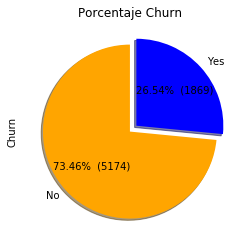

In [12]:
# Balance check

dfChurn['Churn'].value_counts().plot('pie', explode=[0, 0.1], 
  autopct=lambda p : '{:.2f}%  ({:.0f})'.format(p, p*sum(dfChurn['Churn'].value_counts())/100), 
  shadow=True, startangle=90, colors=["orange","blue"]).set_title('Porcentaje Churn') 

plt.show()

Aunque en clase, se comentó que un DataSet desbalanceado podría considerarse hasta un 15%, se hizo un apunte en el que un 26.5% también, debería considerarse como DataSet desbalanceado. Esto es algo importante a tener en cuenta cuando hagamos el **split** a los dataset de entrenamiento y test. Será necesario aplicar técnicas para paliar éste hándicap, técnicas como **Cross Validation**, **Over Sampling**, **Under Sampling**.

Para las variables numéricas, veremos la distribución global y compararemos la distribución con la variable objetivo (Churn = "Yes", Churn = "No").

###Variables Numéricas

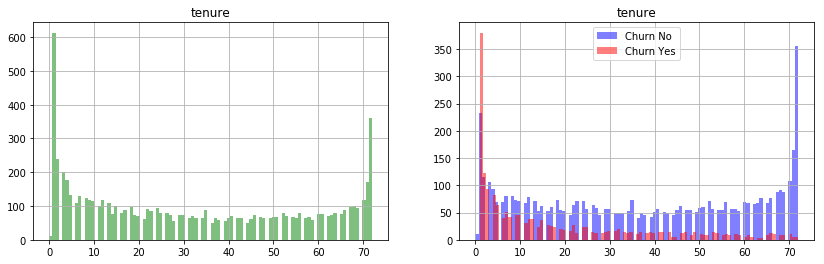

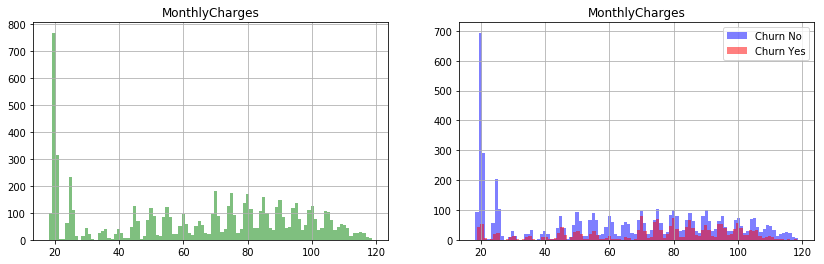

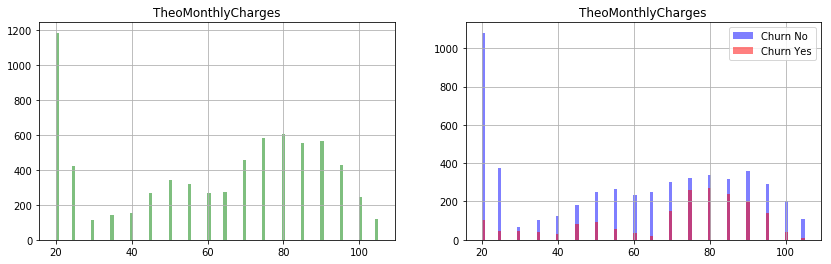

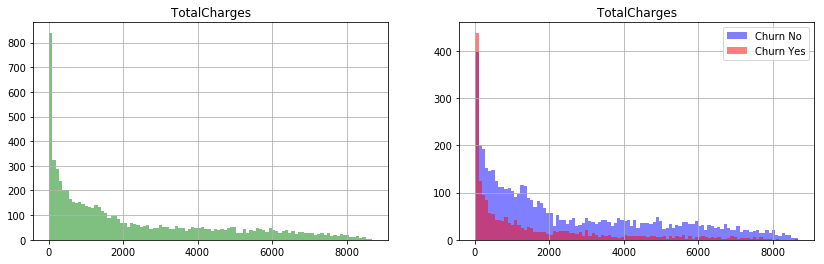

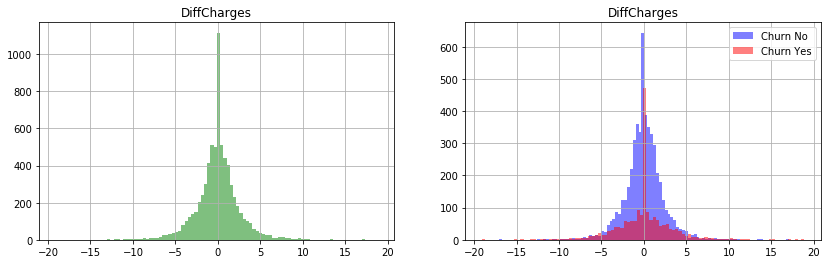

In [13]:
  for numeric_var in numeric_vars:
    histogramChar(dfChurn, numeric_var, None)

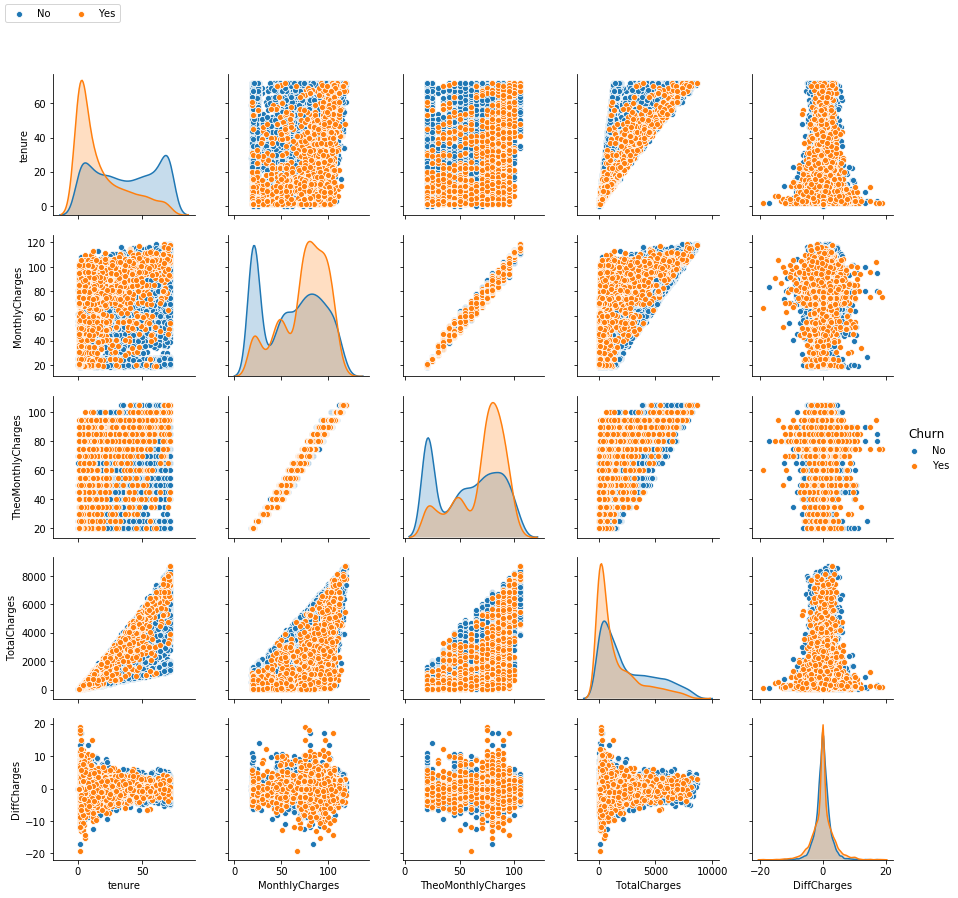

In [14]:
g = sns.pairplot(dfChurn[numeric_vars + ['Churn']], hue = 'Churn')
#, palette = 'husl', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}
g._legend.get_title().set_fontsize(12)
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper left', ncol=2)
g.fig.subplots_adjust(top=0.92)
plt.show()

De las variables numéricas, podemos ver que:
* Aquellos con cuotas mensuales por debajo de los 25(¿€?), son menos proclives a abandonar. Son clientes, como hemos visto de servicios mayoritarios de Voz. Sin embargo, clientes con cuotas altas (Fibra) parece que tienen mayor tasa de abandono.
* No deja de ser curioso que cuanto menor sea el valor de **tenure**, mayor es la tasa de abandono. Si la variable tenure indica el tiempo que el cliente lleva en la compañía, eso indica que muchos clientes nuevos abandonan. Algo que coincide con la variable **TotalCharges** ya que la cantidad cobrada es pequeña. Sería interesante analizar si existe alguna relación con los servicios contratados o con el resto de variables.
* Exceptuando **DiffCharges**, las distribuciones se alejan mucho de una normal. Si **DiffCharges** indica cambios de contrato, podemos observar que, hay mucha concentración en clientes que no cambian de contrato, siendo la variación al alza y a la baja de 5, es decir, de servicios añadidos de Voz (**MultipleLines**) o datos (**Online, TechSupport, etc..**).



### Variables Categóricas

Vamos a analizar las variables categóricas. Mostraremos tres gráficos por cada variable:

*   Porcentaje de cada valor.
*   Porcentaje de cada valor para aquellos registros con Churn "No".
*   Porcentaje de cada valor para aquellos registros con Churn "Yes".

También, mostraremos la relación de churn con cada valor de cada una de las variables categóricas.


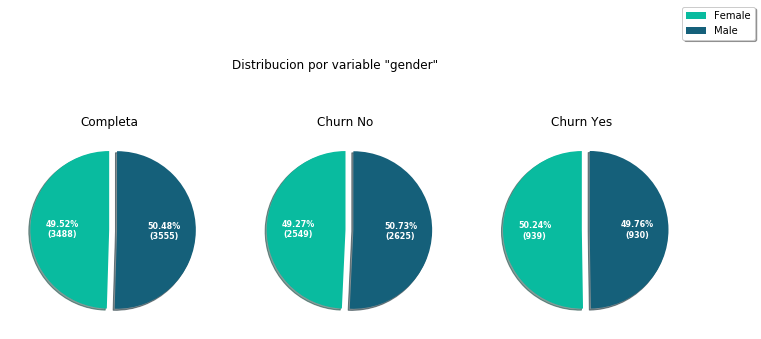

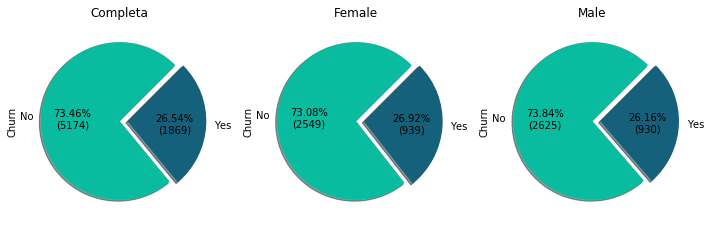

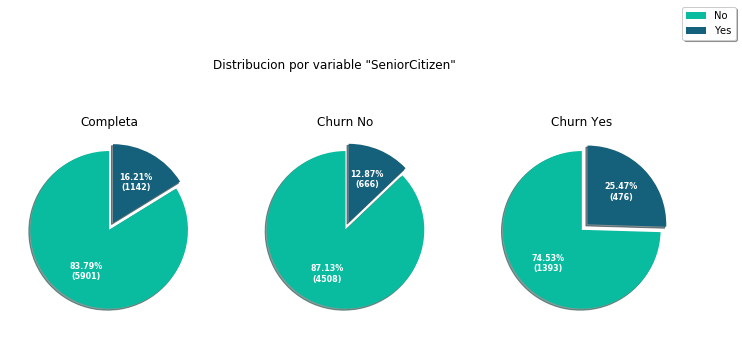

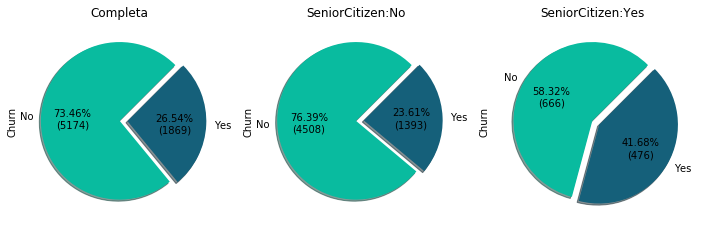

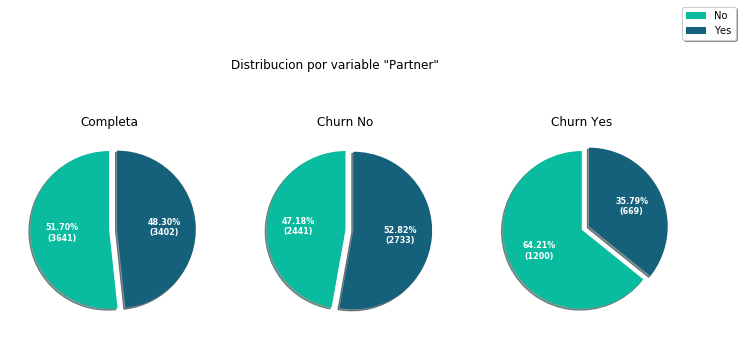

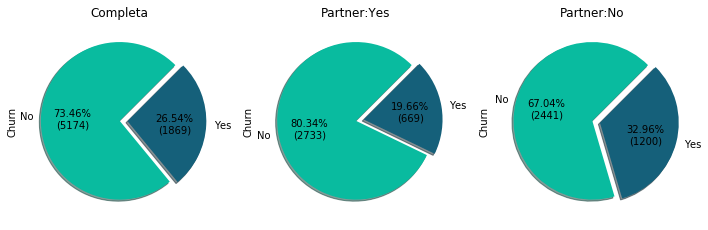

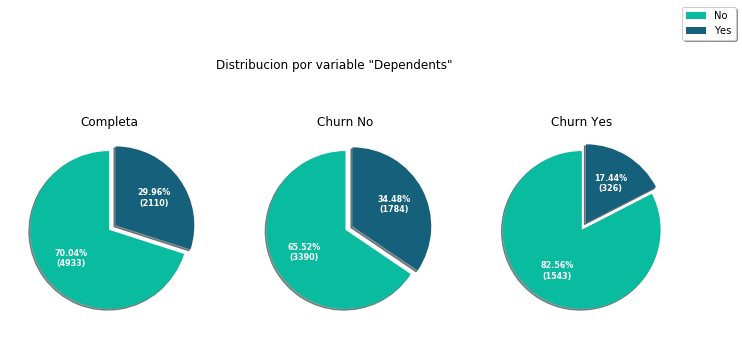

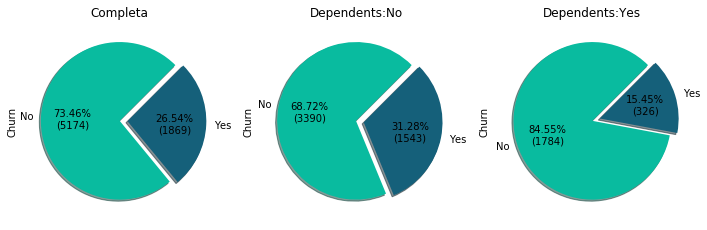

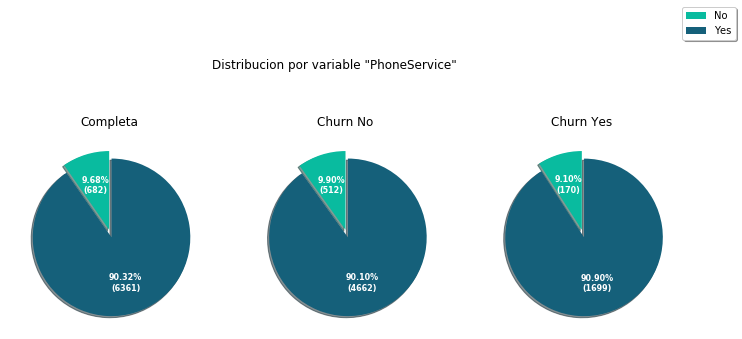

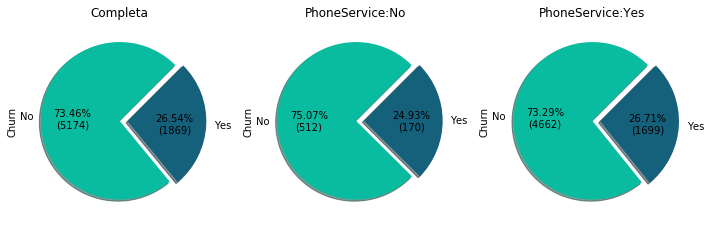

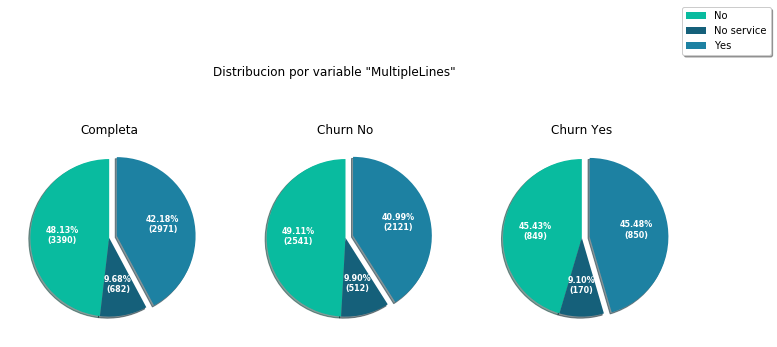

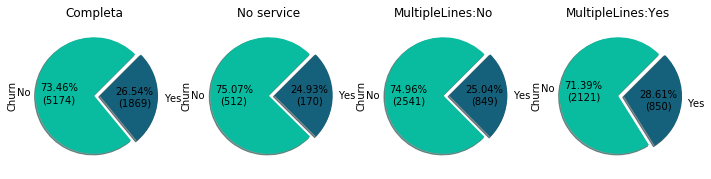

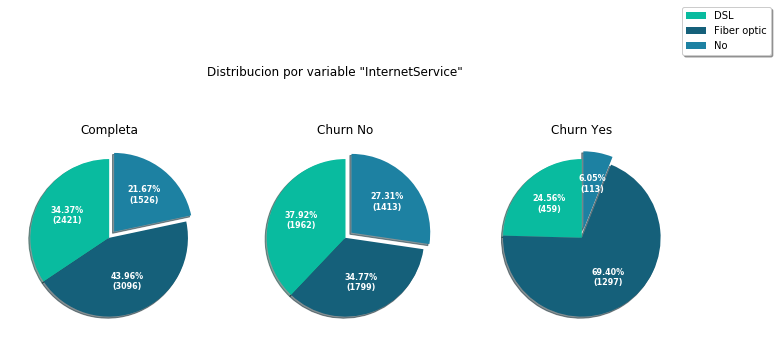

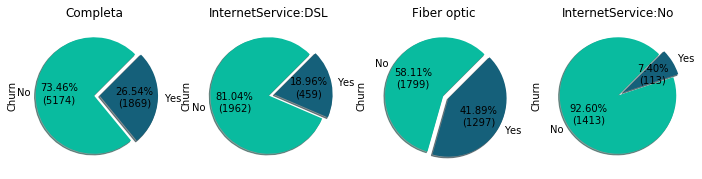

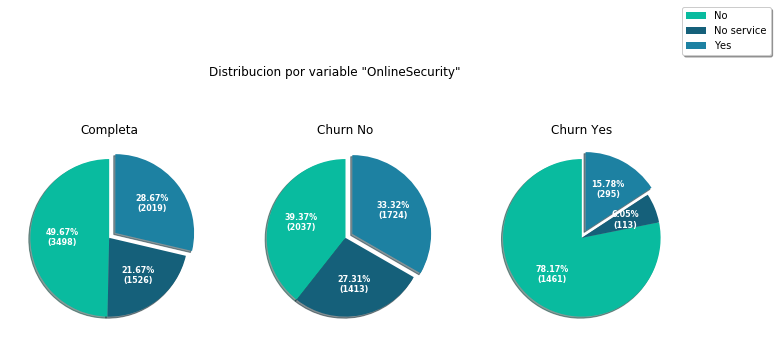

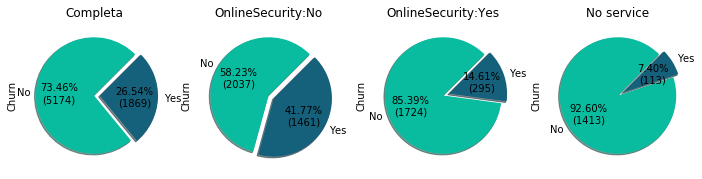

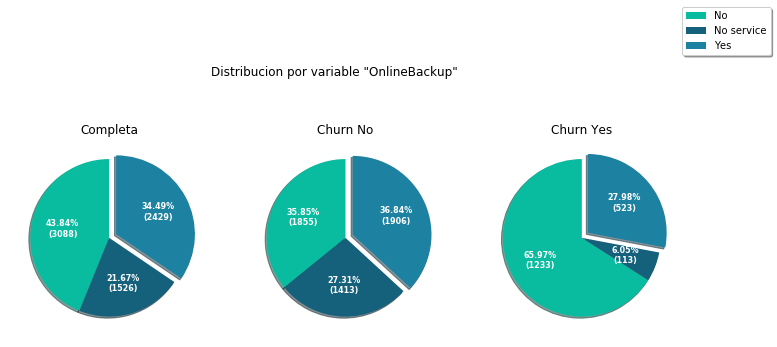

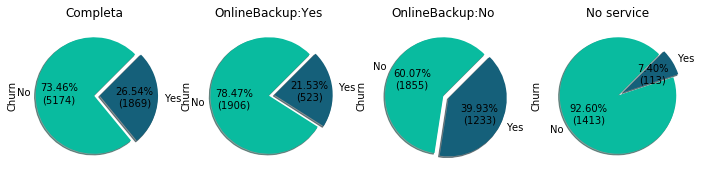

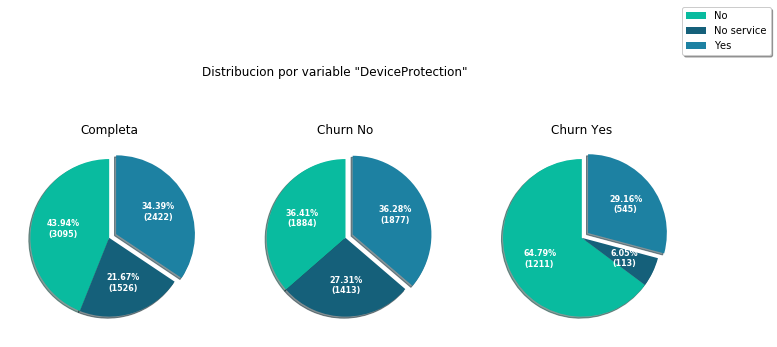

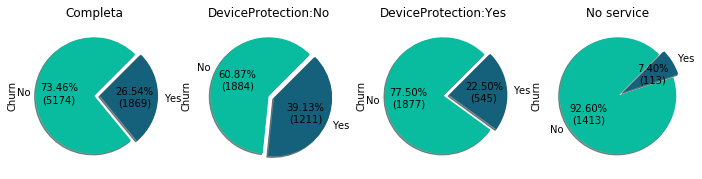

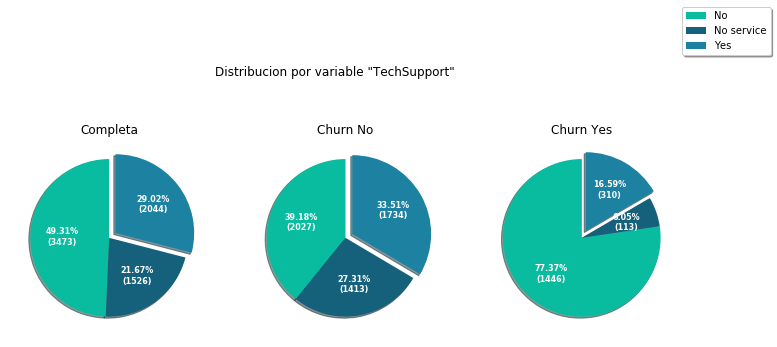

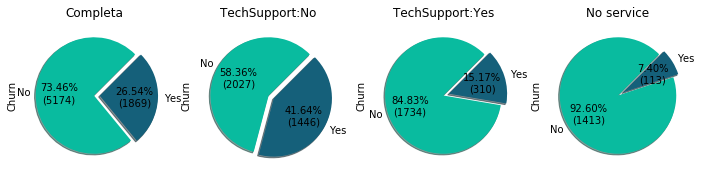

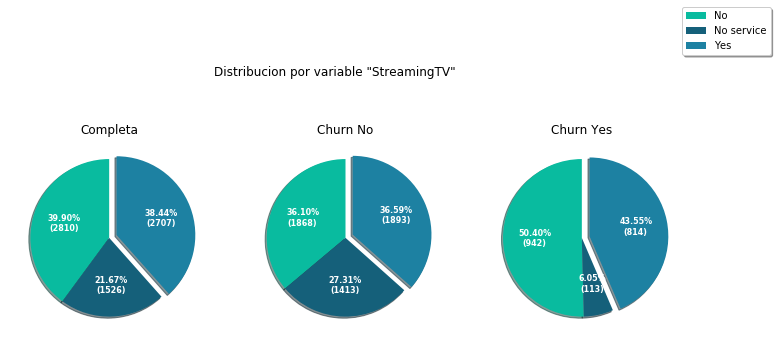

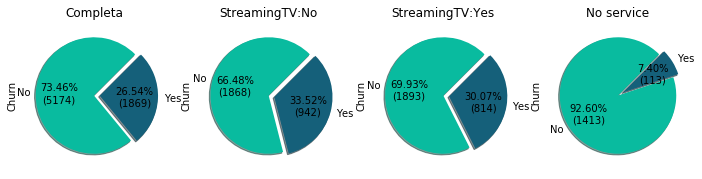

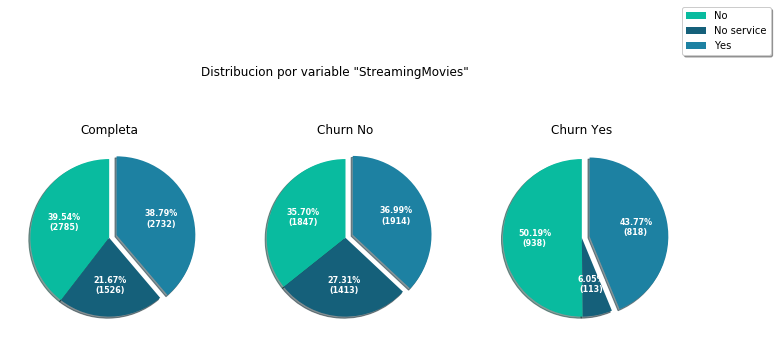

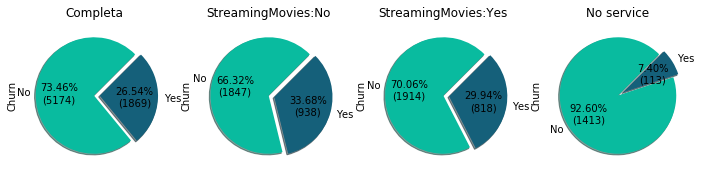

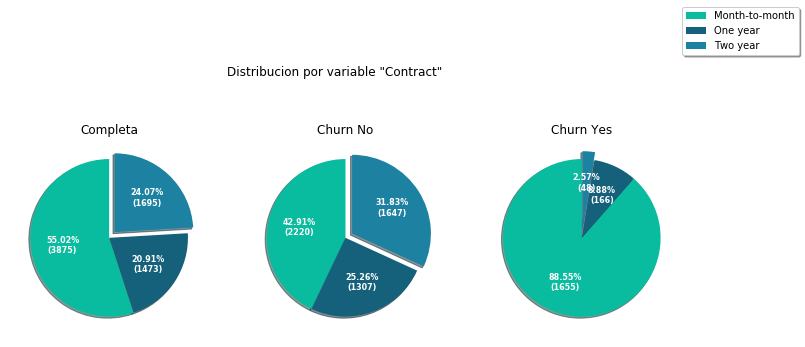

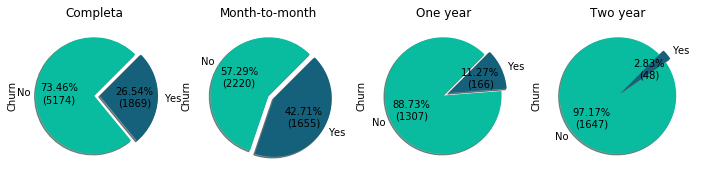

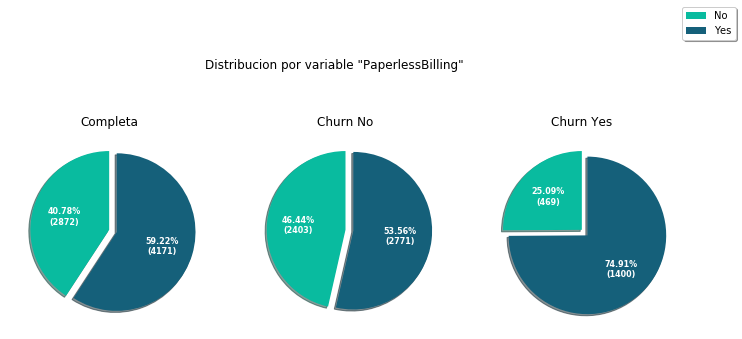

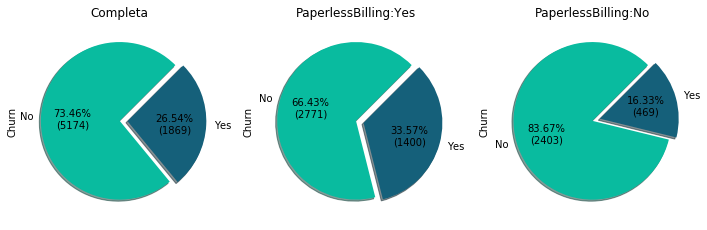

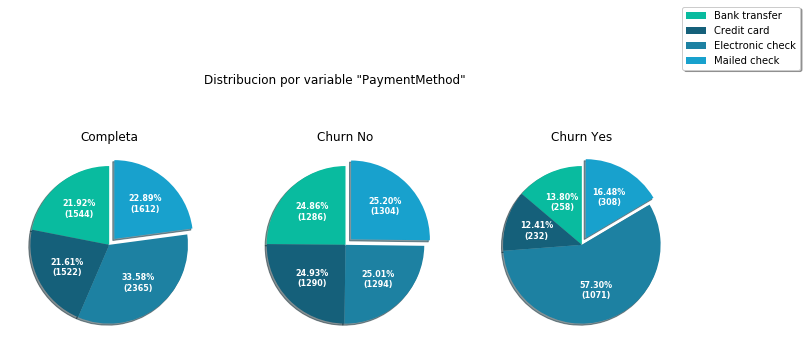

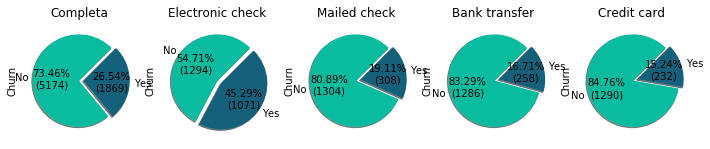

In [15]:
for categoric_var in categoric_vars:
  pieChar(dfChurn, categoric_var, ['churn', 'var'])

**gender**. Prácticamente, existe el mismo número de clientes de sexo masculino y femenino. En concreto, 67 registros más del sexo masculino. Esta relación se mantiene tanto en aquellos que abandonan como los que no. Quizás, destacar que el porcentaje de sexo femenino sube en aquellos clientes que abandonan pero la tasa no es tan alta como para indicar que las mujeres son **menos fieles**. Fijarse, además, que la relación de Churn por cada género es muy parecido al global. Por todo ello, parece que ésta variable no es significativa como para tenerla en cuenta en la predicción.


**SeniorCitizen**. Los “senior citizen” tienen bastante menos representación teniendo una tasa de abandono superior al global. Sí parece que ser Senior Citizen o no puede condicionar la tasa de abandono.


**Partner**. Sí parece variable significativa, reduciendo el churn en aquellos clientes cuyo valor de Partner es Yes. 


**Dependents**. Igual que Partners, sí parece reducir la tasa cuando el valor es Yes.


**PhoneService**. No tan acuciante como en **gender**, la relación de clientes que tienen Servicio Teléfonico se mantiene aunque sí que es cierto que puede haber más churn si se dispone de Servicio Telefónico contratado; aunque se podría justificar, simplemente porque hay más volumen de clientes que tienen Servicio Telefónico contratado.


**MultipleLines**. Parece que disponer o no de múltiples líneas sí puede penalizar el churn. Por otro lado, parece interesante analizar si merece la pena agrupar en **No** aquello que no tienen Múltiples Líneas porque no tienen servicio contratado y aquellos que no tienen porque no disponen de Servicio Telefónico contratado.


**InternetService**. Parece que el servicio de fibra provoca más tasa de abandono frente al servicio de ADSL.


**OnlineSecurity**. Disponer de éste servicio, sí parece retener a los clientes. De la misma forma que en **MultipleLines**, parece interesante analizar el agrupar en **No** los que no tienen contratado el servicio por no disponer de Servicio de Internet o por no haberlo contratado.


**OnlineBackup**. No tanto como el anterior, disponer de éste servicio, sí parece retener a los clientes. Igual que antes, analizar el agrupar en **No**.


**DeviceProtection**. No igual que OnlineSecurity pero mejor que OnlineBackup, disponer de éste servicio reduce la tasa de abandono. Igual que antes, analizar el agrupar en **No**.



**TechSupport**. De forma análoga y con un porcentaje mejor que OnlineSecurity, disponer de éste servicio reduce la tasa de abandono. Igual que antes, analizar el agrupar en **No**.


**StreamingTV**. No parece que éste servicio sea uno de los mejores de la compañía ya que disponer o no de él no cambia significativamente, o al menos, de forma similar a los otros servicios de valor añadido. Quizás, la razón esté en el servicio de Fibra ofrecido; por lo que puede haber una relación directa entre el servicio de Fibra y el Servicio de Streaming TV. Igual que antes, analizar el agrupar en **No**.


**StreamingMovies**. Muy similar a StreamingTV, no parece ser uno de los mejores servicios que proporciona la compañía. Igual que antes, analizar el agrupar en **No**.


**Contract**. El tipo de contrato determina de una forma muy clara la tasa de abandono siendo muy pequeña en el contrato "**Two years**". Puede que incluso, cuanto más largo sea el tiempo del contrato, también, sea mayor la permanencia exigida al cliente.


**PaperlessBilling**. ¡¡Jamás hubiera pensado que no disponer de factura electrónica podría llegar a mejorar la tasa de abandono!! ¿Puede ser que el cliente tenga más asequible la factura? En cuyo caso, ¿puede ser que la compañía tenga problemas de facturación y provoque el abandono?


**PaymentMethod**. Parece que el método de pago "**Electronic check**"  es el que más penaliza la tasa de abandono.

### Selección de Variables

Disponemos de varias técnicas para poder seleccionar aquellas variables más interesantes de cara al modelado. Según se indicó en clase, la elección de las variables es todo un "arte" y puede hacer cambiar la bondad del modelo de forma radical. Debe haber un compromiso entre aquellas variables que proporcionan "señal" al modelo sin que sean demasiado predictoras para evitar **overfitting**.

Plantearemos tres enfoques:

*   WOE e IV. Es una herramienta muy poderosa porque nos proporciona unos intervalos para decidir qué variable debe quedar dentro o fuera.
*   Matriz de Correlación. De la misma manera, se puede ver la correlación de todas las variables con la variable objetivo y decidir con cuál quedarse.
*   RFE. Utilizando el modelo ML, se itera varias veces hasta quedarse con las variables que mejor scoring proporcionan.
*   Algún modelo como Decission Tree que proporciona las features más importantes y su peso.



####WOE e IV

En Python, no parece existir "de caja" una librería para implementar tanto el Information Value como el WOE. Sin embargo, hay paquetería extra para poderlo ejecutar. Todas las librerías estudiadas requieren discretizar las variables numéricas. Algunos, como la usada utilizan el **coeficiente de correlación Spearman**. Hay mucha literatura de cómo discretizar variables numéricas:


*   Rango de valores bien asegurando el mismo número de elementos en cada rango bien de forma discrecional.
*   Utilizando los percentiles y cómo de desplazada está la media.
*   Utilizando algoritmos de clustering como K-Means aunque algunos aconsejan, en tal caso, utilizar otros algoritmos como **Jenks Natural Breaks**. Parece más interesante utilizar éste algoritmo en casos en los que sólo se desea clusterizar una única variable. Para conocer el total de clases, se utiliza el **Goodness of Variance Fit**, siendo 0 = No Fit y 1 = Fit; interesa no poner un valor de 1 para evitar posibles problemas de overfitting.

Para utilizar éste algoritmo, es necesario instalar un paquete **pip install jenkspy**.




tenure [0.0, 20.0, 48.0, 72.0] [1 2 3]


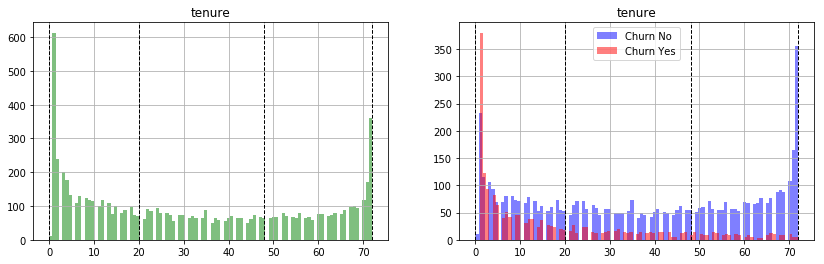

MonthlyCharges [18.25, 42.4, 77.8, 118.75] [1 2 3]


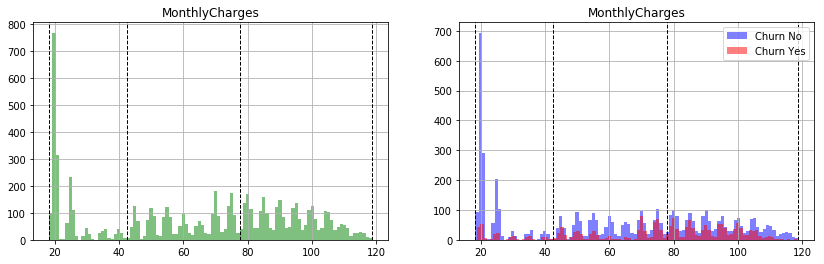

TheoMonthlyCharges [20.0, 40.0, 70.0, 105.0] [1 2 3]


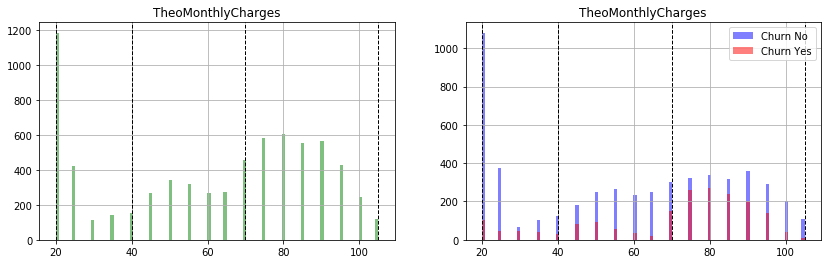

TotalCharges [18.8, 1980.3, 4786.15, 8684.8] [1 2 3]


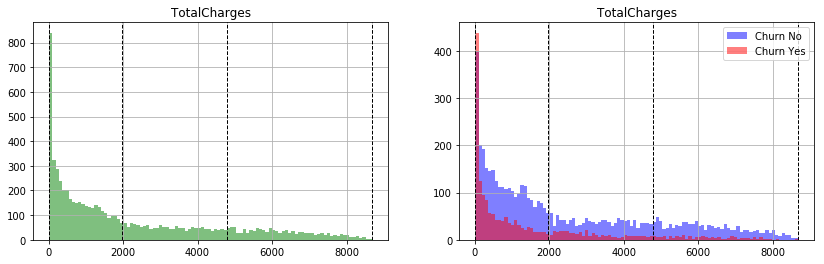

DiffCharges [-19.125, -4.5643, -1.2257, 1.2062, 4.82, 18.9] [1 2 3 4 5]


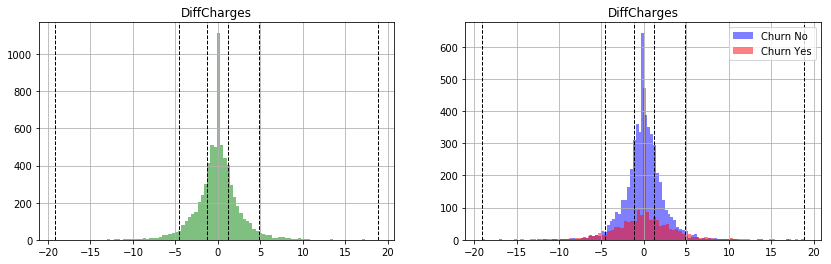

In [8]:
categoric_extra_vars = []
for numeric_var in numeric_vars:
  gvf = 0.0
  nclasses = 2
  while gvf < .85:
    gvf, classified, breaks = goodness_of_variance_fit(dfChurn[numeric_var], nclasses)
    nclasses += 1
  dfChurn[numeric_var + '_bin'] = classified
  dfChurn[numeric_var + '_bin'] = dfChurn[numeric_var + '_bin'].astype('str')
  categoric_extra_vars.append(numeric_var + '_bin')
  print(numeric_var, breaks, np.unique(classified))
  histogramChar(dfChurn, numeric_var, breaks)



Parecen acertados éstos rangos, si además, los comparamos con los percentiles y la media.

In [17]:

#dfChurn['target'] = dfChurn['Churn'].apply(lambda x : 1 if x == 'Yes' else 0)
final_iv, IV = data_vars(dfChurn[categoric_vars + categoric_extra_vars], dfChurn.target)

final_iv.sort_values(['VAR_NAME', 'MIN_VALUE', 'MAX_VALUE'])

VAR_NAME         MIN_VALUE  ...       WOE        IV
34                Contract    Month-to-month  ...  0.724536  1.238560
35                Contract          One year  ... -1.045259  1.238560
36                Contract          Two year  ... -2.517267  1.238560
6               Dependents                No  ...  0.231141  0.155488
7               Dependents               Yes  ... -0.681473  0.155488
22        DeviceProtection                No  ...  0.576292  0.499725
23        DeviceProtection        No service  ... -1.507840  0.499725
24        DeviceProtection               Yes  ... -0.218402  0.499725
55         DiffCharges_bin                 1  ...  0.929295  0.084243
56         DiffCharges_bin                 2  ... -0.009245  0.084243
57         DiffCharges_bin                 3  ... -0.133421  0.084243
58         DiffCharges_bin                 4  ... -0.050598  0.084243
59         DiffCharges_bin                 5  ...  0.950990  0.084243
13         InternetService               DSL  ... -0.434427  0.617953
14         InternetService       Fiber optic  ...  0.691066  0.617953
15         InternetService                No  ... -1.507840  0.617953
46      MonthlyCharges_bin                 1  ... -0.963812  0.258231
47      MonthlyCharges_bin                 2  ...  0.090036  0.258231
48      MonthlyCharges_bin                 3  ...  0.378169  0.258231
10           MultipleLines                No  ... -0.078011  0.008207
11           MultipleLines        No service  ... -0.084284  0.008207
12           MultipleLines               Yes  ...  0.103836  0.008207
19            OnlineBackup                No  ...  0.609808  0.528634
20            OnlineBackup        No service  ... -1.507840  0.528634
21            OnlineBackup               Yes  ... -0.274938  0.528634
16          OnlineSecurity                No  ...  0.685886  0.717777
17          OnlineSecurity        No service  ... -1.507840  0.717777
18          OnlineSecurity               Yes  ... -0.747185  0.717777
37        PaperlessBilling                No  ... -0.615628  0.203068
38        PaperlessBilling               Yes  ...  0.335507  0.203068
4                  Partner                No  ...  0.308156  0.118729
5                  Partner               Yes  ... -0.389129  0.118729
39           PaymentMethod    Bank transfer   ... -0.588090  0.457109
40           PaymentMethod      Credit card   ... -0.697418  0.457109
41           PaymentMethod  Electronic check  ...  0.829097  0.457109
42           PaymentMethod      Mailed check  ... -0.424849  0.457109
8             PhoneService                No  ... -0.084284  0.000745
9             PhoneService               Yes  ...  0.008838  0.000745
2            SeniorCitizen                No  ... -0.156151  0.105621
3            SeniorCitizen               Yes  ...  0.682371  0.105621
31         StreamingMovies                No  ...  0.340675  0.381374
32         StreamingMovies        No service  ... -1.507840  0.381374
33         StreamingMovies               Yes  ...  0.168154  0.381374
28             StreamingTV                No  ...  0.333624  0.380462
29             StreamingTV        No service  ... -1.507840  0.380462
30             StreamingTV               Yes  ...  0.174285  0.380462
25             TechSupport                No  ...  0.680487  0.699567
26             TechSupport        No service  ... -1.507840  0.699567
27             TechSupport               Yes  ... -0.703371  0.699567
49  TheoMonthlyCharges_bin                 1  ... -0.917894  0.340024
50  TheoMonthlyCharges_bin                 2  ... -0.400740  0.340024
51  TheoMonthlyCharges_bin                 3  ...  0.488329  0.340024
52        TotalCharges_bin                 1  ...  0.266629  0.151769
53        TotalCharges_bin                 2  ... -0.234122  0.151769
54        TotalCharges_bin                 3  ... -0.815956  0.151769
0                   gender            Female  ...  0.019602  0.000380
1                   gender  

In [18]:
IV['Power'] = pd.np.where(IV['IV']<0.02, 'Useless',
  pd.np.where(IV['IV']<0.1, 'Weak',
  pd.np.where(IV['IV']<0.3, 'Medium',
  pd.np.where(IV['IV']<0.5, 'Strong', 'Suspicious'
))))
IV.sort_values('IV', ascending=False)
#IV.to_csv("iv.csv", sep=";", decimal=",")

VAR_NAME        IV       Power
0                 Contract  1.238560  Suspicious
8           OnlineSecurity  0.717777  Suspicious
16             TechSupport  0.699567  Suspicious
20              tenure_bin  0.641171  Suspicious
4          InternetService  0.617953  Suspicious
7             OnlineBackup  0.528634  Suspicious
2         DeviceProtection  0.499725      Strong
11           PaymentMethod  0.457109      Strong
14         StreamingMovies  0.381374      Strong
15             StreamingTV  0.380462      Strong
17  TheoMonthlyCharges_bin  0.340024      Strong
5       MonthlyCharges_bin  0.258231      Medium
9         PaperlessBilling  0.203068      Medium
1               Dependents  0.155488      Medium
18        TotalCharges_bin  0.151769      Medium
10                 Partner  0.118729      Medium
13           SeniorCitizen  0.105621      Medium
3          DiffCharges_bin  0.084243        Weak
6            MultipleLines  0.008207     Useless
12            PhoneService  0.000745     Useless
19                  gender  0.000380     Useless

Como ya intuímaos, podemos observar que hay variables muy predictoras como puedan ser **Contract** o **tenure**. Así mismo, hay variables que no afectan al churn como pueda ser **gender**. Según la literatura, deberíamos quedarnos con las variables **Strong** y/o **Medium**, descartando el resto.

####Matriz de Correlación

Dada la cantidad de variables categóricas existentes, ir combinando de dos en dos o incluso de tres en tres, las distintas variables puede ser una tarea ardua. Se podría abordar ejecutando PCA reduciendo así el total de dimensiones aunque una aproximación interesante puede ser utilizar la matriz de correlación con el método **kendall** (útil para variables nominales). Esto nos obliga a convertir a numéricas, todas las variables categóricas.

Podemos ver la relación de las variables con la **target** y de forma equivalente al **IV**, cuáles son más determinantes de cara al Churn. Para ello, un corte del 15% puede ser una buena opción para eliminar todas aquellas no determinantes.

In [19]:
categoric_total_vars   = categoric_vars + categoric_extra_vars
dfBinaryChurn = dfChurn[categoric_total_vars + ['target']].copy()


#Binary columns with 2 values
binary_vars = dfBinaryChurn[categoric_total_vars].nunique()[dfBinaryChurn.nunique() == 2].keys().tolist()

#Columns more than 2 values
multi_vars = [i for i in categoric_total_vars if i not in binary_vars]


for var in binary_vars:
  dfBinaryChurn[var]= pd.np.where((dfBinaryChurn[var]=='Yes') | (dfBinaryChurn[var]=='Female'), 1, 0)
    
#Duplicating columns for multi value columns
dfBinaryChurn = pd.get_dummies(data = dfBinaryChurn, columns = multi_vars)

dfCorrChurn = dfBinaryChurn.corr(method='kendall').abs()
dfChurnDependency = dfCorrChurn[dfCorrChurn.index=='target']
dfChurnDependency = dfChurnDependency.unstack().reset_index()
dfChurnDependency.columns = ['var', 'drop', 'value']
#dfChurnDependency.loc[dfChurnDependency['value']>0.15][['var', 'value']].to_csv("corr.csv", sep=";", decimal=",")
dfChurnDependency.loc[dfChurnDependency['value']>0.15][['var', 'value']].sort_values(by='value', ascending=False)

var     value
6                           target  1.000000
31         Contract_Month-to-month  0.405103
13               OnlineSecurity_No  0.342637
22                  TechSupport_No  0.337281
38                    tenure_bin_1  0.320594
11     InternetService_Fiber optic  0.308020
33               Contract_Two year  0.302253
36  PaymentMethod_Electronic check  0.301919
16                 OnlineBackup_No  0.268005
40                    tenure_bin_3  0.266758
19             DeviceProtection_No  0.252481
46        TheoMonthlyCharges_bin_3  0.240601
23          TechSupport_No service  0.227890
29      StreamingMovies_No service  0.227890
26          StreamingTV_No service  0.227890
20     DeviceProtection_No service  0.227890
17         OnlineBackup_No service  0.227890
14       OnlineSecurity_No service  0.227890
12              InternetService_No  0.227890
41            MonthlyCharges_bin_1  0.197958
5                 PaperlessBilling  0.191825
44        TheoMonthlyCharges_bin_1  0.189270
32               Contract_One year  0.177820
15              OnlineSecurity_Yes  0.171226
24                 TechSupport_Yes  0.164674
3                       Dependents  0.164221
43            MonthlyCharges_bin_3  0.151947
1                    SeniorCitizen  0.150889
2                          Partner  0.150448
47              TotalCharges_bin_1  0.150434

De forma equivalente, vemos que hay variables muy determinantes como **Contract** o **tenure** y otras mucho menos como **gender**.

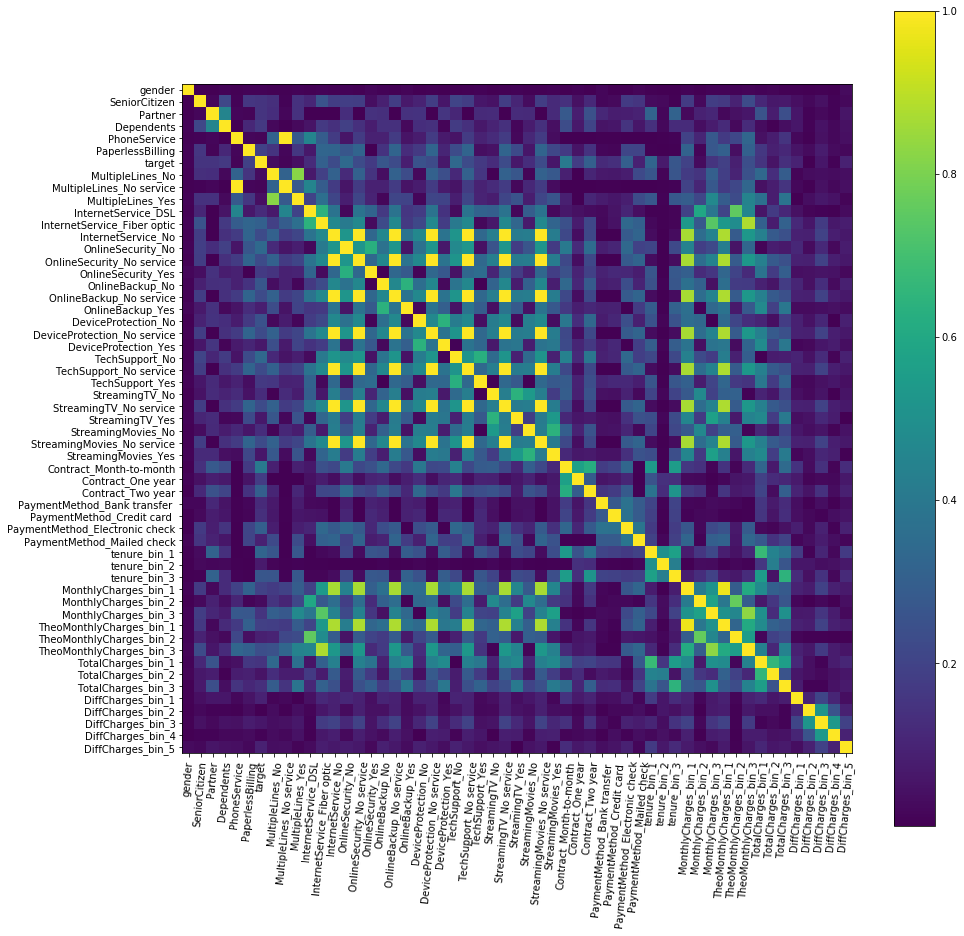

In [20]:
plt.figure(figsize=(15,15))
plt.imshow(dfCorrChurn, cmap='viridis')
plt.xticks(range(len(dfCorrChurn.columns)), dfCorrChurn.columns, rotation=85)
plt.yticks(range(len(dfCorrChurn.columns)), dfCorrChurn.columns)
plt.colorbar()
plt.show()

In [21]:
dfCorrTable = dfCorrChurn.unstack().reset_index()
dfCorrTable.columns= ['a', 'b', 'value']
dfCorrTable = dfCorrTable.loc[(dfCorrTable['a']!=dfCorrTable['b']) & (dfCorrTable['value']>0.70)]
dfCorrTable = dfCorrTable.sort_values(by='value', ascending=False)
dfCorrTable

a                            b     value
228                  PhoneService     MultipleLines_No service  1.000000
444      MultipleLines_No service                 PhoneService  1.000000
1442       StreamingTV_No service           InternetService_No  1.000000
1112  DeviceProtection_No service           InternetService_No  1.000000
1114  DeviceProtection_No service    OnlineSecurity_No service  1.000000
1117  DeviceProtection_No service      OnlineBackup_No service  1.000000
1123  DeviceProtection_No service       TechSupport_No service  1.000000
1126  DeviceProtection_No service       StreamingTV_No service  1.000000
1129  DeviceProtection_No service   StreamingMovies_No service  1.000000
1277       TechSupport_No service           InternetService_No  1.000000
1279       TechSupport_No service    OnlineSecurity_No service  1.000000
1282       TechSupport_No service      OnlineBackup_No service  1.000000
1285       TechSupport_No service  DeviceProtection_No service  1.000000
1294       TechSupport_No service   StreamingMovies_No service  1.000000
1444       StreamingTV_No service    OnlineSecurity_No service  1.000000
961       OnlineBackup_No service       StreamingTV_No service  1.000000
1447       StreamingTV_No service      OnlineBackup_No service  1.000000
1450       StreamingTV_No service  DeviceProtection_No service  1.000000
1453       StreamingTV_No service       TechSupport_No service  1.000000
1459       StreamingTV_No service   StreamingMovies_No service  1.000000
1607   StreamingMovies_No service           InternetService_No  1.000000
1609   StreamingMovies_No service    OnlineSecurity_No service  1.000000
1612   StreamingMovies_No service      OnlineBackup_No service  1.000000
1615   StreamingMovies_No service  DeviceProtection_No service  1.000000
1618   StreamingMovies_No service       TechSupport_No service  1.000000
1621   StreamingMovies_No service       StreamingTV_No service  1.000000
964       OnlineBackup_No service   StreamingMovies_No service  1.000000
1291       TechSupport_No service       StreamingTV_No service  1.000000
958       OnlineBackup_No service       TechSupport_No service  1.000000
677            InternetService_No      OnlineBackup_No service  1.000000
...                           ...                          ...       ...
704            InternetService_No     TheoMonthlyCharges_bin_1  0.876649
2440     TheoMonthlyCharges_bin_1  DeviceProtection_No service  0.876649
2437     TheoMonthlyCharges_bin_1      OnlineBackup_No service  0.876649
2434     TheoMonthlyCharges_bin_1    OnlineSecurity_No service  0.876649
2432     TheoMonthlyCharges_bin_1           InternetService_No  0.876649
1639   StreamingMovies_No service     TheoMonthlyCharges_bin_1  0.876649
2284         MonthlyCharges_bin_1   StreamingMovies_No service  0.868096
701            InternetService_No         MonthlyCharges_bin_1  0.868096
811     OnlineSecurity_No service         MonthlyCharges_bin_1  0.868096
2281         MonthlyCharges_bin_1       StreamingTV_No service  0.868096
2278         MonthlyCharges_bin_1       TechSupport_No service  0.868096
2275         MonthlyCharges_bin_1  DeviceProtection_No service  0.868096
2272         MonthlyCharges_bin_1      OnlineBackup_No service  0.868096
2269         MonthlyCharges_bin_1    OnlineSecurity_No service  0.868096
2267         MonthlyCharges_bin_1           InternetService_No  0.868096
1306       TechSupport_No service         MonthlyCharges_bin_1  0.868096
1471       StreamingTV_No service         MonthlyCharges_bin_1  0.868096
1141  DeviceProtection_No service         MonthlyCharges_bin_1  0.868096
1636   StreamingMovies_No service         MonthlyCharges_bin_1  0.868096
976       OnlineBackup_No service         MonthlyCharges_bin_1  0.868096
2573     TheoMonthlyCharges_bin_3         MonthlyCharges_bin_3  0.830503
2411         MonthlyCharges_bin_3     TheoMonthlyCharges_bin_3  0.830503
502             MultipleLines_Yes             MultipleLines_No  0.822853
394              

Aplicando un valor de correlación mayor de 0.70, podemos concluir que:


*   Podemos agrupar MultipleLines en dos valores Yes/No.
*   Podemos agrupar los servicios de valor añadido de datos (Streaming, Online, etc..) en dos valores Yes/No.
*  Hay ciertos servicios de datos de valor añadidos que están correlados, parece todo apuntar a que debe existir algún tipo de oferta **pack** de servicios aunque, como hemos visto, a nivel facturación no parece haber descuento por pack ya que cada servicio va por separado.
*  La cuota mensual de 18.25 a 42.4 está asociada a servicios **No Fibra**, Voz y DLS y pocos servicios de valor añadido, tal y como vimos al calcular los precios aproximados.
*  La cuota mensual de 77.8 a 118.75 está asociada a servicios de **Internet Fibra** tal y como ya habíamos visto.



In [0]:
categoric_total_vars   = categoric_vars + categoric_extra_vars
dfBinaryChurn = dfChurn[categoric_total_vars + ['target']].copy()
for categoric_var in categoric_total_vars:
  dfBinaryChurn[categoric_var] = pd.np.where(dfBinaryChurn[categoric_var]=='No service', 'No', dfBinaryChurn[categoric_var])

#Binary columns with 2 values
binary_vars = dfBinaryChurn[categoric_total_vars].nunique()[dfBinaryChurn.nunique() == 2].keys().tolist()

#Columns more than 2 values
multi_vars = [i for i in categoric_total_vars if i not in binary_vars]


for var in binary_vars:
  dfBinaryChurn[var]= pd.np.where((dfBinaryChurn[var]=='Yes') | (dfBinaryChurn[var]=='Female'), 1, 0)
    
#Duplicating columns for multi value columns
dfBinaryChurn = pd.get_dummies(data = dfBinaryChurn, columns = multi_vars)



####Diagrama de Afinidad

Parece interesante hacer un Diagrama de Araña para ver posibles **afinidades** entre clientes lo cual podría proporcionar clusters y tipifcarlos con poco, mucho riesgo, o simplemente, proporcionar a negocio un conjunto de clientes tipo para realizar **campañas** específicas.

Sacaremos el porcentaje de elementos por cada valor de cada variable:

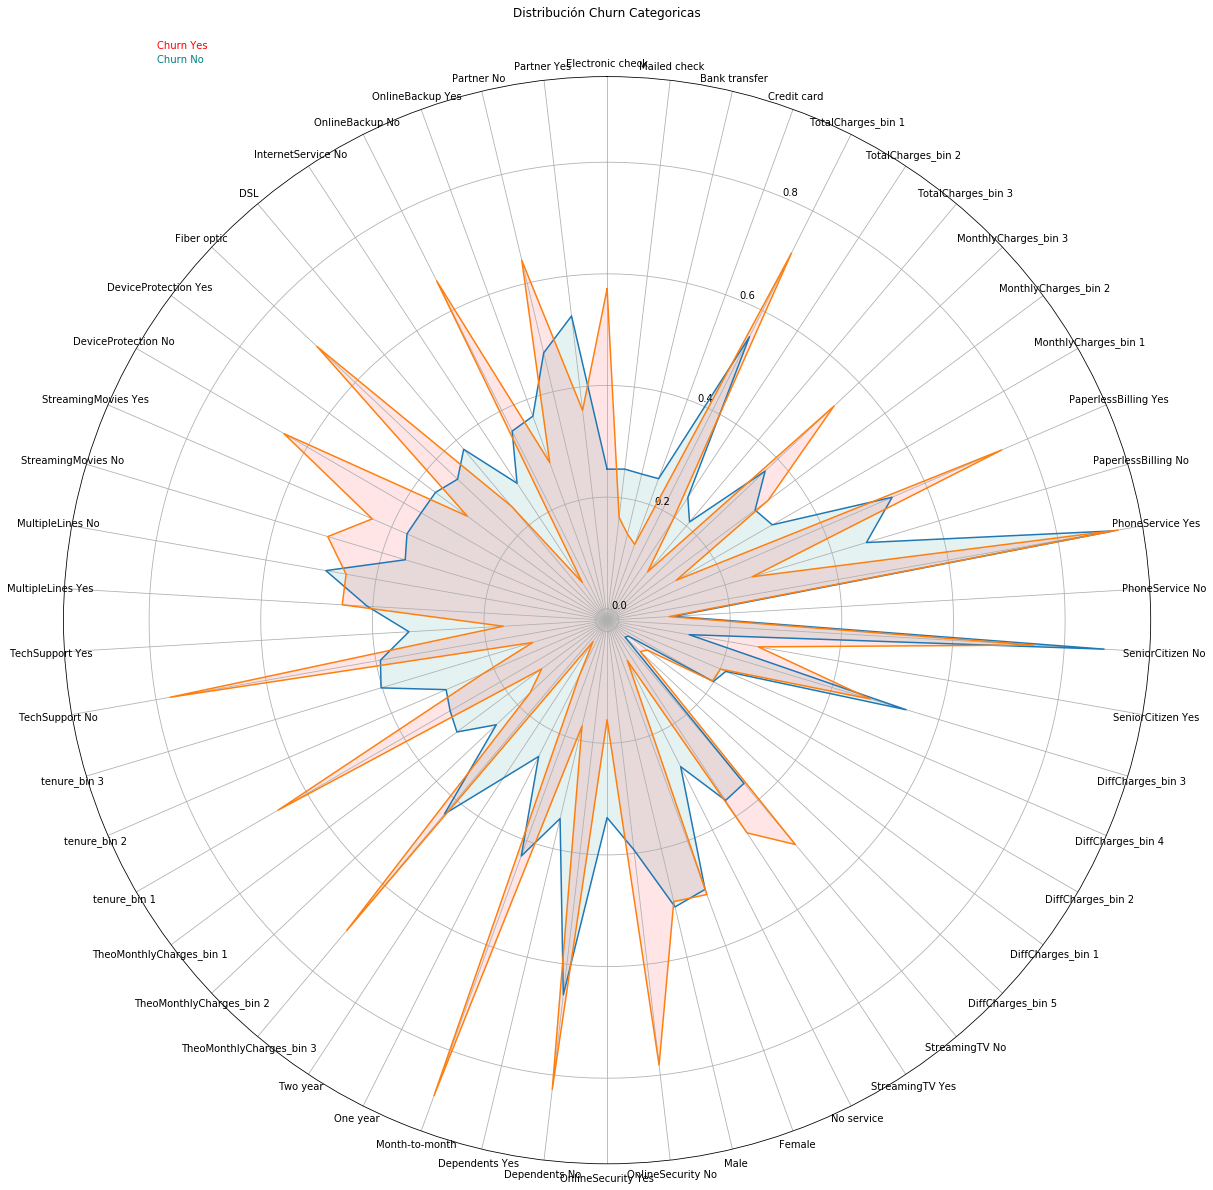

In [23]:
from math import pi

categoric_total_vars = list(set(categoric_vars + categoric_extra_vars) - set(['target', 'Churn']))
#categoric_total_vars = ['SeniorCitizen']
radars_var = {}
for i in ['Yes','No']:
  dfFilterChurn = dfChurn.loc[dfChurn['Churn']==i]
  for categoric_var in categoric_total_vars:
    values_count = dfFilterChurn[categoric_var].value_counts()
    for variable_count in values_count.index:
      if variable_count in ['Yes', 'No']:
        radar_var = categoric_var + ' ' + variable_count
      elif categoric_var[-4:]=='_bin':
        radar_var = categoric_var + ' ' + variable_count
      else:
        radar_var = variable_count
      if not radar_var in radars_var:
        radars_var[radar_var] = {'Yes': 0.0, 'No':0.0}
      radars_var[radar_var][i] = (values_count[values_count.index==variable_count]/values_count.sum()).to_list()
    
num_vars = len(radars_var)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles+=angles[:1]

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], [key for key in radars_var.keys()])


values_Yes = [value['Yes'] for value in radars_var.values()]
values_Yes+=values_Yes[:1]
values_No = [value['No'] for value in radars_var.values()]
values_No+=values_No[:1]

ax.plot(angles, values_No)
ax.fill(angles, values_No, 'teal', alpha=0.1, linewidth=2)

ax.plot(angles, values_Yes)
ax.fill(angles, values_Yes, 'red', alpha=0.1, linewidth=2)

ax.set_title("Distribución Churn Categoricas")
ax.grid(True)

plt.figtext(0.2,0.9,"Churn Yes",color="red")
plt.figtext(0.2,0.89,"Churn No",color="teal")
plt.show()


De forma general, a grandes rasgos:
* Clientes nuevos (tenure<3).
* Clientes de Fibra.
* Clientes sin servicios valor añadido contratados exceptuando Streaming.
* Clientes con contrato mensual.
* Clientes sin “Dependents” y sin “Partners”
**Son clientes potenciales de Churn**


### Estudio "casos interesantes"

####Clientes con cuota menor de 25

Vamos a analizar si alguno de estos clientes no tienen representación en algún valor de las variables categóricas, lo cual, podría determinar tipos de servicio contratado. Se puede apurar más y extender el valor de corte a **30**.

In [0]:
dfFilterChurn = dfChurn[dfChurn['MonthlyCharges']<30].reset_index()

In [25]:
dfValues = pd.DataFrame(columns=['label', 'totals_filter', 'totals'])
for categoric_var in categoric_vars:
  dfCount = dfChurn[categoric_var].value_counts().reset_index()
  dfCount.columns = ['label', 'totals']
  dfCountFilter = dfFilterChurn[categoric_var].value_counts().reset_index()
  dfCountFilter.columns = ['label', 'totals_filter']
  dfCountFilter = dfCountFilter.merge(dfCount, left_on='label', right_on='label', how='outer')
  dfCountFilter['label'] = [categoric_var + '_' + str(i) for i in dfCountFilter['label']]
  dfValues = pd.concat([dfValues, dfCountFilter])
  
dfValues[dfValues['totals_filter'].isnull()].head(50)

label totals_filter totals
2  InternetService_Fiber optic           NaN   3096
2              StreamingTV_Yes           NaN   2707
2          StreamingMovies_Yes           NaN   2732

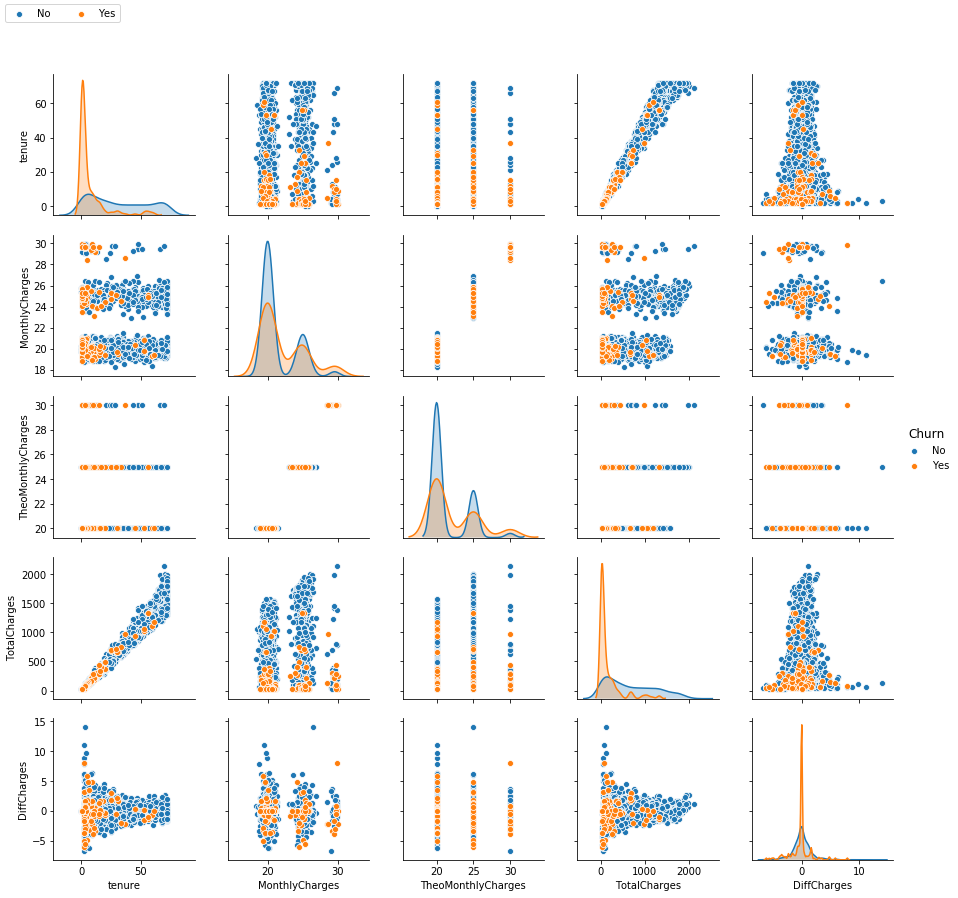

In [26]:
g = sns.pairplot(dfFilterChurn[numeric_vars + ['Churn']], hue = 'Churn')
#, palette = 'husl', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}
g._legend.get_title().set_fontsize(12)
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper left', ncol=2)
g.fig.subplots_adjust(top=0.92)
plt.show()

Parece que es un servicio muy interesante para la Empresa: Clientes con apenas antigüedad, parecen bastante fieles.

Como ya parecía constatarse, los clientes que contratan Fibra y, en consecuencia, algún servicio de Streaming, además, de tener una couta superior, parece existir una tasa de abandono clara. Quizás, el servicio no cumple las expectativas del cliente, quizás, la competencia tiene mejor servicio / oferta.

####Clientes nuevos

Parece que servicios de Fibra junto con Contrato **month-to-month** son una "bomba explosiva" que favorece el Churn de clientes. Parece claro que el contrato determina la permanencia y aunque la permanencia no está nada bien valorada por los **clientes** y éste tipo de contratos podría haber sido un buen gancho para atraer clientes, no se pensó bien en el tipo de servicio bien en el precio con respecto a la competencia. Habría que ahondar más en el por qué clientes con tan poco tiempo en la compañía deciden marcharse.

In [0]:
dfFilterChurn = dfChurn[dfChurn['tenure']<3].reset_index()

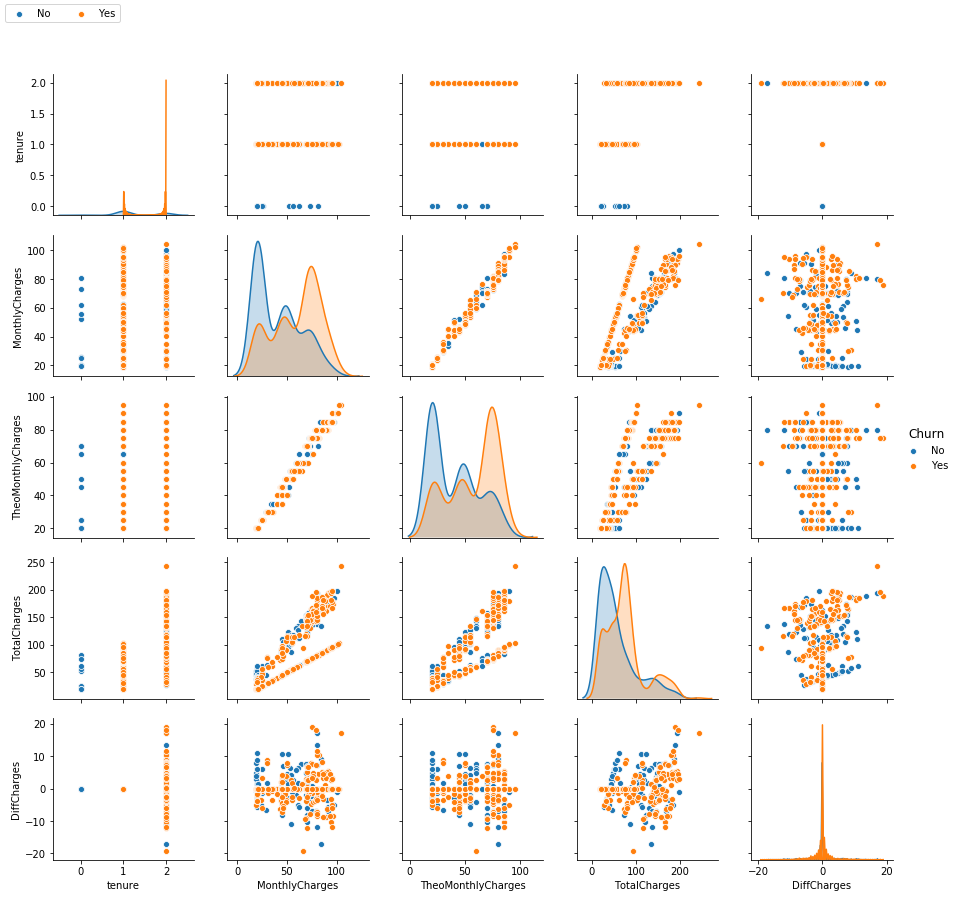

In [28]:
g = sns.pairplot(dfFilterChurn[numeric_vars + ['Churn']], hue = 'Churn')
#, palette = 'husl', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}
g._legend.get_title().set_fontsize(12)
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper left', ncol=2)
g.fig.subplots_adjust(top=0.92)
plt.show()

## Modelado

### OptiML

Utilizando las soluciones existentes (**H2O o BigML**), se pueden ejecutar de forma masiva modelados. Estas herramientas, además, indican cuáles son los mejores para el DataSet cargado.

De los 65 modelos entrenados, Regresión Logística encabeza los cuatro primeros (con un **ROC AUC de 0.83726**) siendo el quinto, un modelo Random Forest (**ROC AUC de 0.83532**). Deep Learning queda muy a la cola y un Arbol de Decisión queda al final (**ROC AUC 0.72135**).

La verdad es que éstas herramienta ponen muy en duda, si vamos a conseguir con nuestros "conocimientos" unos valores similares.... ¡¡veremos!!



### Desbalanceo

Ya hemos comentado que existe un DataSet muy desbalanceado entre los clientes Churn y los clientes no Churn. Esto, dependiendo del DataSet de entrenamiento y Test que se utilice puede hacer que el accuracy sea mejor o peor, puede que incluso aparezca overfittin. En consencuencia, es necesario utilizar técnicas como **Cross Validation** o **SMOTE** y paliar ese posible overfitting / underfitting.

Python, para ello, proporciona herramientas muy potentes para utilizar ambas técnicas.

### Selección de Entidades

Cuando indicamos el término Entidades, hacemos referencia a usar aquellas **variables** más "interesantes" para el modelado así como los **hiper parámetros** que optimizar dicho modelo.

También, por suerte, Python tiene utilidades para hacernos la "vida" más sencilla, hablamos de **GridSearch** o **RandomSearch** para determinar los hiper parámetros y **RFE** para determinar las variables. Además, existe la opción de incluir Cross Validation en el estudio RFE (**RFECV**)

### Modelos

Aplicaremos las distintas técnicas a diferentes modelos para ver cuál da mejor resultado. En un DataSet desbalanceado y dónde prima que el modelo detecte lo mejor posible aquellos clientes que se pueden marchar de la compañía, cómo métrica de scoring para optimizar los modelos, usaremos **f1** o **roc_auc**. 

Para extrapolar a otros modelos, las cosas más particulares a tener en cuenta, serían:

*   Hiper parámetros de cada modelo.
*   Peculiaridades de cada modelo como por ejemplo que un Decission Tree o un AdaBoost poseen **feature importance** y una Regresión Logística no. Modelos como K-Vecinos o GaussianNB no publican los coeficientes, por lo que **RFE** o **RFECV** no se pueden aplicar. Por suerte, existe una libreria (**SequentialFeatureSelector**) que aunque más lenta sí permite realizar la misma lógica que RFE sin necesidad de que los algoritmos publiquen coef_. 
*  Otra opción podría haber sido haber ejecutado **fuerza bruta**. Haber hecho la combinatoria de todas las variables y que gane la mejor. Sin embargo, ésto se iba mucho más en tiempos.

Utilizaremos **Cross Validation** con un total de 10 iteraciones (**Folds**) y calcularemos valores medios. Para la matriz de confusión, sumaremos los distintos valores de cada Fold y normalizaremos los valores.

De los distintos algoritmos, seleccionaremos algunos de los vistos en clase aunque el portfolio existente es inmenso. **SVC** aunque ya se comentó que daba muy buenos resultados, lo dejaremos fuera, simplemente, por el tiempo de procesamiento que implica.

In [0]:
#http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
models = {
  'LR': LogisticRegression(),
  'LDA': LinearDiscriminantAnalysis(),
  'KNN': KNeighborsClassifier(),
  'CART': DecisionTreeClassifier(),
  'NB': GaussianNB(),
  'ADABOOST': AdaBoostClassifier()
}
#  'SVM': SVC(probability=True)

#Ciertos modelos como KNN no exportan coef_ por lo que no se puede usar RFECV

scorings = ['f1', 'roc_auc']


#### LabelEncoding vs OneHotEncoding (get_dummies)

Haremos una primera comparativa viendo si se mejora o no usando una u otra técnica. OneHotEncoding tiene un hándicap y es que el número de variables que se generan puede llegar a ser elevado, lo cual podría penalizar la capacidad de cómputo.

In [0]:
categoric_total_vars   = categoric_vars + categoric_extra_vars
le = preprocessing.LabelEncoder()

dfLabelEncodeChurn = dfChurn.copy()

for categoric_var in categoric_total_vars:
  dfLabelEncodeChurn[categoric_var] = pd.np.where(dfLabelEncodeChurn[categoric_var]=='No service', 'No', dfLabelEncodeChurn[categoric_var])

X_labelencode_columns = [column for column in dfLabelEncodeChurn.columns if column not in ['target','Churn','customerID']]

for column in X_labelencode_columns:
  dfLabelEncodeChurn[column] = le.fit_transform(dfLabelEncodeChurn[column])
y_labelencode_columns = ['target'] #, 'Churn',



In [0]:
X_labelencode = dfLabelEncodeChurn[X_labelencode_columns]
y_labelencode = dfLabelEncodeChurn[y_labelencode_columns]

In [40]:
'''
Este codigo tarda mucho tiempo. Por eso, tenemos en fichero los datos JSON
models_label_features = {}
for name, model in models.items():
  if name!='SVC':
    models_label_features[name] = selectFeatures(X_labelencode, y_labelencode, model, name, scorings)

f= open("features_label.txt","w") 
f.write(json.dumps(models_label_features))
f.close()    
'''


LR
Número óptimo de variables (f1) : 22 de 26
variables seleccionadas:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TheoMonthlyCharges', 'tenure_bin', 'MonthlyCharges_bin', 'TotalCharges_bin', 'DiffCharges_bin']
variables eliminadas:
['DiffCharges', 'MonthlyCharges', 'TheoMonthlyCharges_bin', 'TotalCharges']
LR
Número óptimo de variables (roc_auc) : 25 de 26
variables seleccionadas:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'TheoMonthlyCharges', 'tenure_bin', 'MonthlyCharges_bin', 'TheoMonthlyCharges_bin', 'Total

Podemos observar que, dependiendo de la métrica a optimizar, el conjunto de **variables** cambia en el mismo algoritmo. En general, para optimizar **roc_auc**, se requieren más variables. Decidir qué métrica usar es todo un arte. Hay mucha literatura que indica cuál es mejor dependiendo del DataSet. Quizás, en un entorno productivo, se tendrían entrenados varios modelos y se utilizaría uno u otro dependiendo del cliente a predecir.

Unas primeras pruebas con **SVC** dan ratios muy similares a **ADABOOST** pero mucho más lento. Si un ADABOOST tarda 0.52seg de media, un SVC se va a 22.34seg de media.

In [0]:
import json
f= open("features_label.json","r") 
models_label_features = json.loads(f.read())
f.close()


In [0]:
dfFeatures = pd.DataFrame()
for name_label, model_label in models_label_features.items():
  dfFeatures = pd.concat([dfFeatures, pd.DataFrame({
      'dataset': ['LabelEncoding'],
      'model': [name_label],
      'f1': [model_label['f1']['max_score']],
      'roc_auc': [model_label['roc_auc']['max_score']]
  })])
  


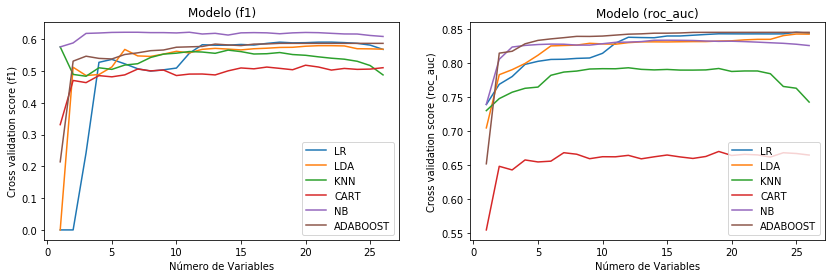

In [30]:
paintFeaturesSelectionModels(models_label_features)

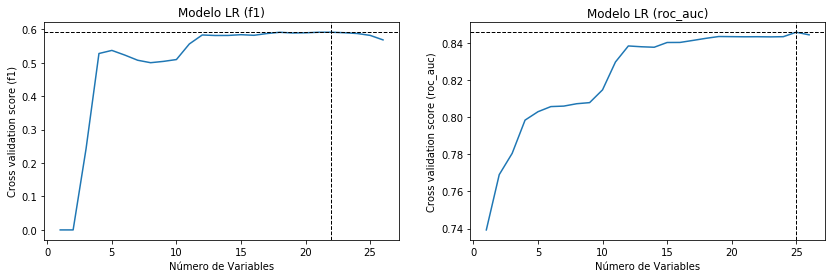

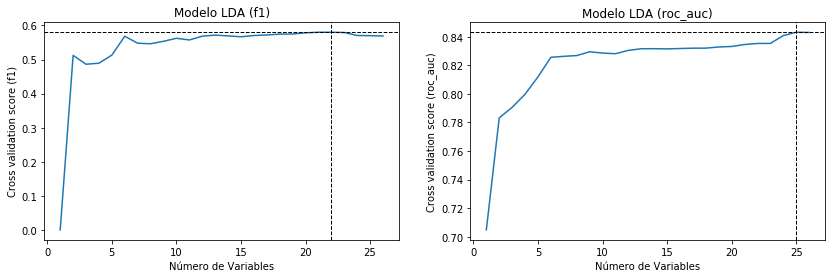

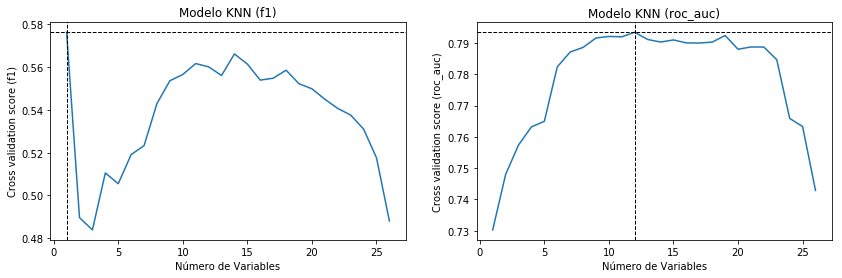

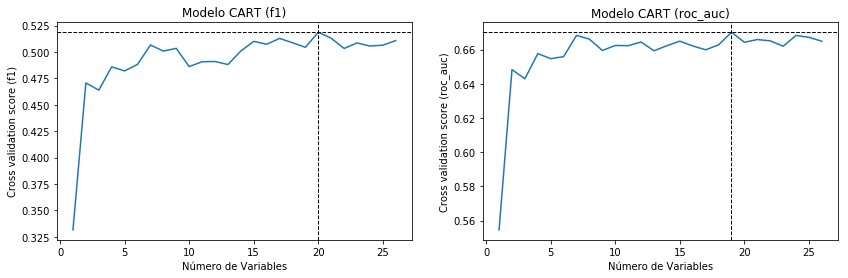

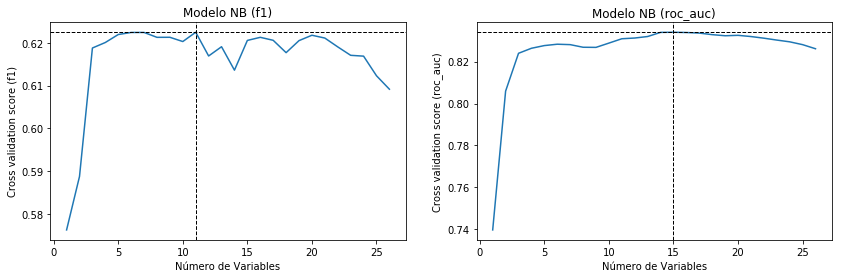

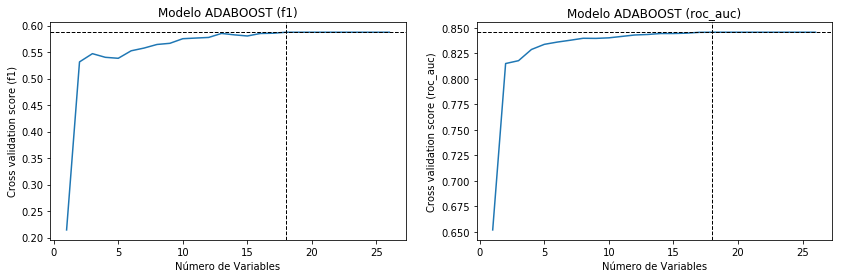

In [15]:
for name, model in models_label_features.items():
  paintFeaturesSelection(model, name)

In [0]:
dfParams = pd.DataFrame()

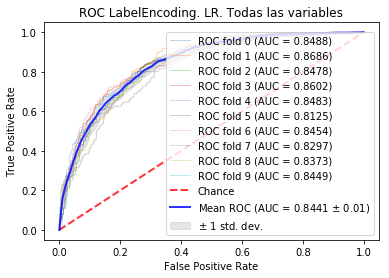

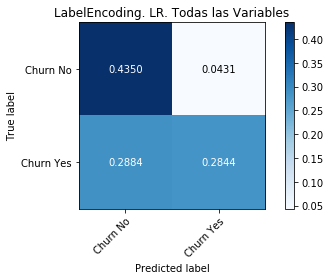

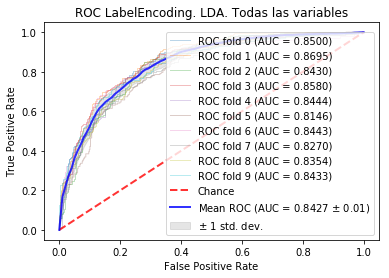

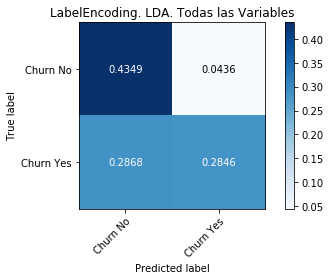

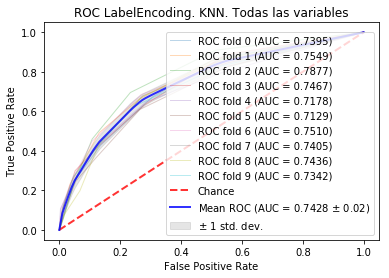

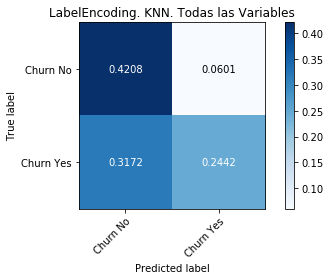

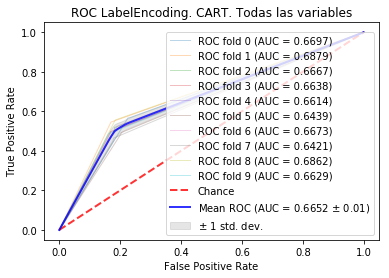

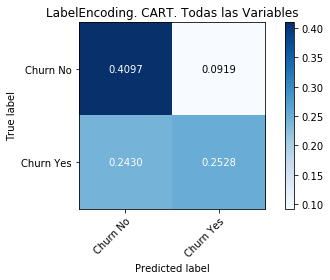

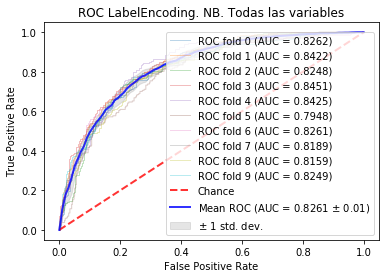

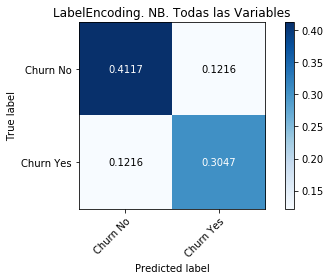

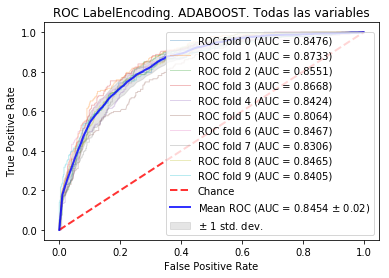

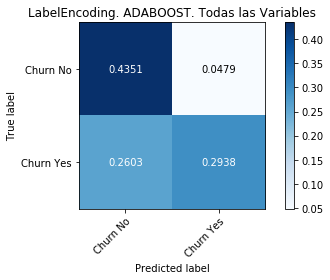

In [95]:
models_label_metrics = {'all':{}, 'filter':{}}
for name, model in models.items():
  models_label_metrics['all'][name] = paintROCCurve(X_labelencode, y_labelencode, model, 'ROC LabelEncoding. ' + name + '. Todas las variables')
  dfParams = pd.concat([dfParams, createParamsDataFrame(models_label_metrics['all'][name], name, 'LabelEncoding', 'Todas Variables', '')])
  paintConfusionMatrix(models_label_metrics['all'][name], normalize=True, title='LabelEncoding. ' + name + '. Todas las Variables')



f1
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TheoMonthlyCharges', 'tenure_bin', 'MonthlyCharges_bin', 'TotalCharges_bin', 'DiffCharges_bin']


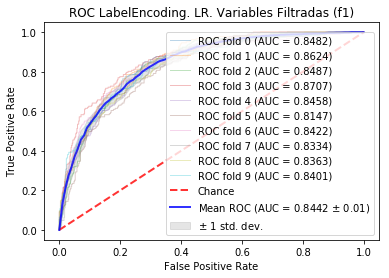

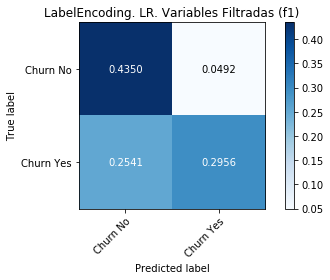

roc_auc
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'TheoMonthlyCharges', 'tenure_bin', 'MonthlyCharges_bin', 'TheoMonthlyCharges_bin', 'TotalCharges_bin', 'DiffCharges_bin']


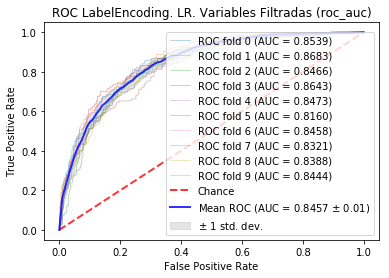

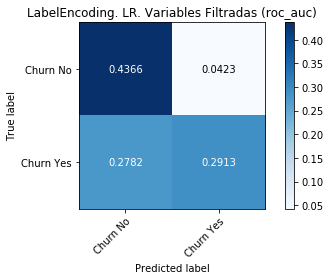

f1
['gender', 'SeniorCitizen', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TheoMonthlyCharges', 'tenure_bin', 'MonthlyCharges_bin', 'TheoMonthlyCharges_bin', 'TotalCharges_bin', 'DiffCharges_bin']


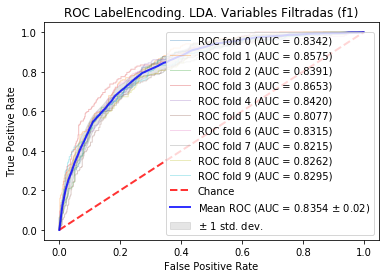

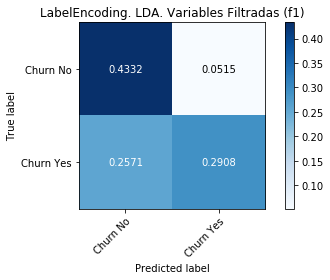

roc_auc
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'TheoMonthlyCharges', 'tenure_bin', 'MonthlyCharges_bin', 'TheoMonthlyCharges_bin', 'TotalCharges_bin', 'DiffCharges_bin']


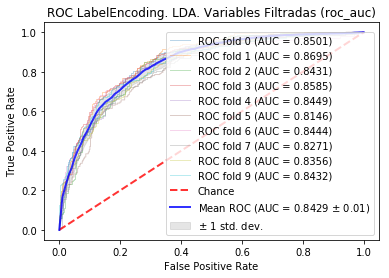

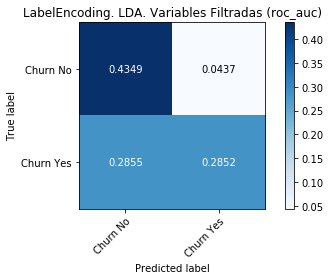

f1
['Contract']


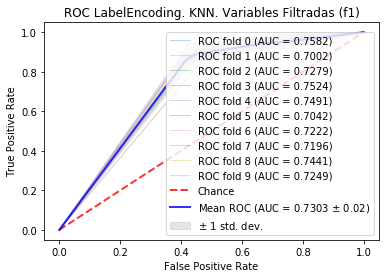

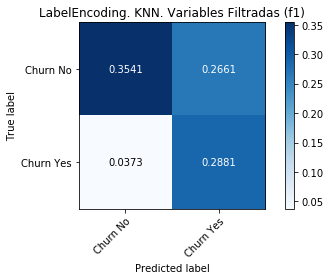

roc_auc
['Contract', 'DiffCharges_bin', 'InternetService', 'MonthlyCharges_bin', 'MultipleLines', 'OnlineSecurity', 'PaperlessBilling', 'StreamingTV', 'TechSupport', 'TheoMonthlyCharges_bin', 'tenure', 'tenure_bin']


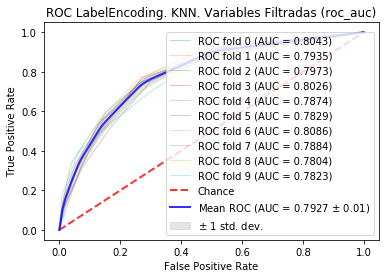

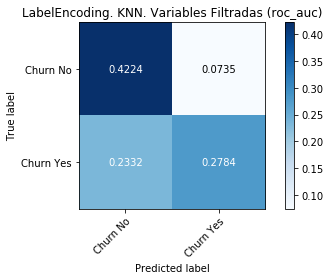

f1
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'DiffCharges', 'TheoMonthlyCharges', 'DiffCharges_bin']


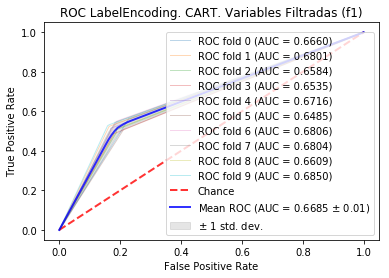

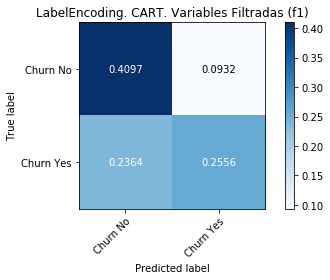

roc_auc
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'DiffCharges', 'TheoMonthlyCharges', 'DiffCharges_bin']


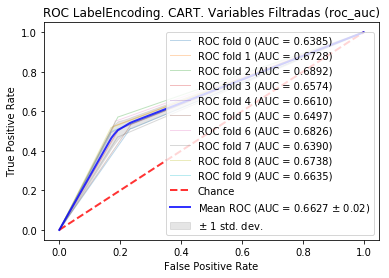

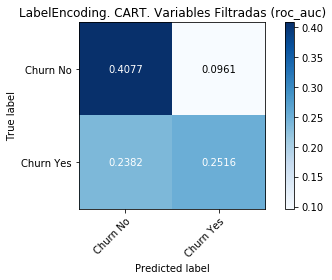

f1
['Contract', 'DeviceProtection', 'DiffCharges', 'InternetService', 'MultipleLines', 'PaymentMethod', 'PhoneService', 'SeniorCitizen', 'StreamingTV', 'gender', 'tenure_bin']


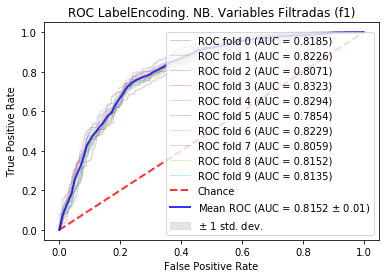

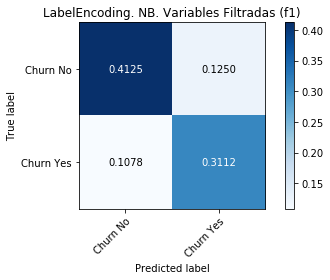

roc_auc
['Contract', 'InternetService', 'MonthlyCharges', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling', 'PaymentMethod', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'TheoMonthlyCharges_bin', 'TotalCharges', 'gender', 'tenure']


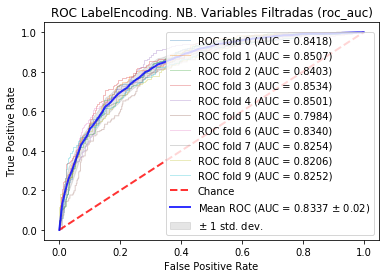

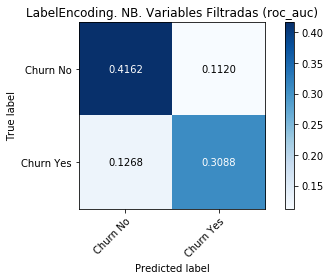

f1
['SeniorCitizen', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'DiffCharges', 'TheoMonthlyCharges', 'tenure_bin']


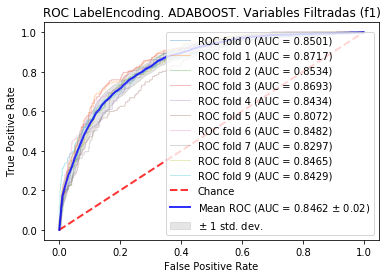

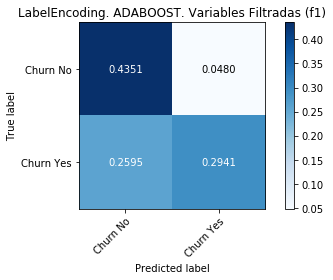

roc_auc
['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'DiffCharges', 'TheoMonthlyCharges']


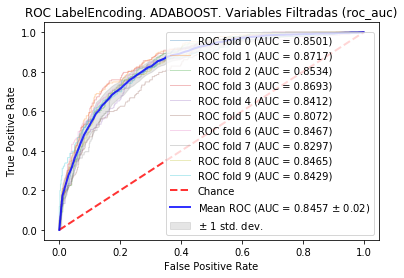

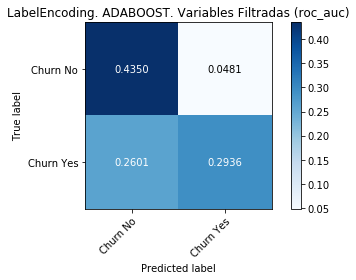

In [96]:
for name, model in models.items():
  for scoring in models_label_features[name]:
    print(scoring)
    features_filter = models_label_features[name][scoring]['in']
    print(features_filter)
    models_label_metrics['filter'][name] = paintROCCurve(X_labelencode[features_filter], y_labelencode, model, 'ROC LabelEncoding. ' + name + '. Variables Filtradas (' + scoring +')')
    dfParams = pd.concat([dfParams, createParamsDataFrame(models_label_metrics['filter'][name], name, 'LabelEncoding', 'Variables Filtradas (' + scoring +')', '')])
    paintConfusionMatrix(models_label_metrics['filter'][name], normalize=True, title='LabelEncoding. ' + name + '. Variables Filtradas (' + scoring +')')


In [0]:
X_binary_columns = [column for column in dfBinaryChurn.columns if column!='target']
y_binary_columns = ['target'] #, 'Churn',

In [0]:
X_binary = dfBinaryChurn[X_binary_columns]
y_binary = dfBinaryChurn[y_binary_columns]

In [64]:
'''
Este codigo tarda mucho tiempo. Por eso, tenemos en fichero los datos JSON
models_binary_features = {}
for name, model in models.items():
  models_binary_features[name] = selectFeatures(X_binary, y_binary, model, name, scorings)

f= open("features_binary.txt","w") 
f.write(json.dumps(models_binary_features))
f.close()
'''

LR
Número óptimo de variables (f1) : 40 de 40
variables seleccionadas:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer ', 'PaymentMethod_Credit card ', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure_bin_1', 'tenure_bin_2', 'tenure_bin_3', 'MonthlyCharges_bin_1', 'MonthlyCharges_bin_2', 'MonthlyCharges_bin_3', 'TheoMonthlyCharges_bin_1', 'TheoMonthlyCharges_bin_2', 'TheoMonthlyCharges_bin_3', 'TotalCharges_bin_1', 'TotalCharges_bin_2', 'TotalCharges_bin_3', 'DiffCharges_bin_1', 'DiffCharges_bin_2', 'DiffCharges_bin_3', 'DiffCharges_bin_4', 'DiffCharges_bin_5']
variables eliminadas:
[]
LR
Número óptimo de variables (roc_auc) : 30 de 4

In [0]:
import json
f= open("features_binary.json","r") 
models_binary_features = json.loads(f.read())
f.close()

In [0]:
for name_binary, model_binary in models_binary_features.items():
  dfFeatures = pd.concat([dfFeatures, pd.DataFrame({
      'dataset': ['Binary'],
      'model': [name_binary],
      'f1': [model_binary['f1']['max_score']],
      'roc_auc': [model_binary['roc_auc']['max_score']]
  })])
  


In [38]:
print(dfFeatures.sort_values('roc_auc', ascending=False).head(1))
print(dfFeatures.sort_values('f1', ascending=False).head(1))

         dataset model        f1   roc_auc
0  LabelEncoding    LR  0.591292  0.845744
  dataset model        f1   roc_auc
0  Binary    NB  0.632709  0.837234


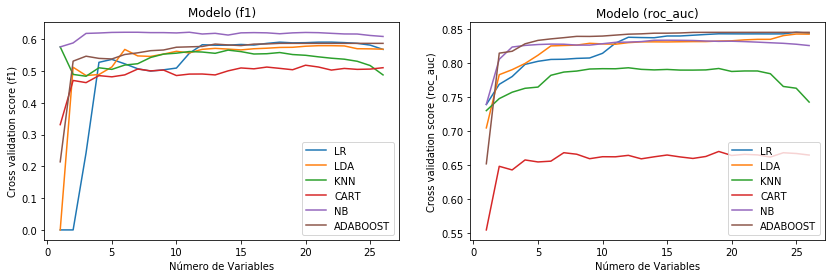

In [39]:
paintFeaturesSelectionModels(models_binary_features)

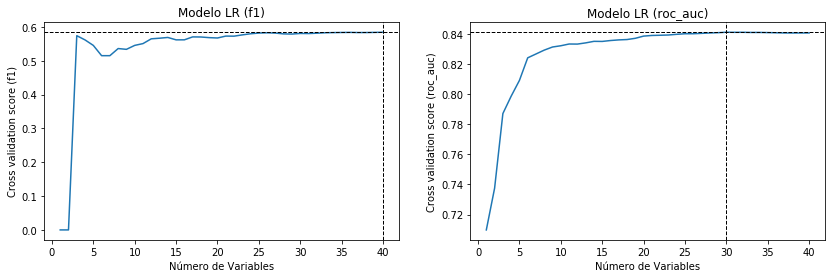

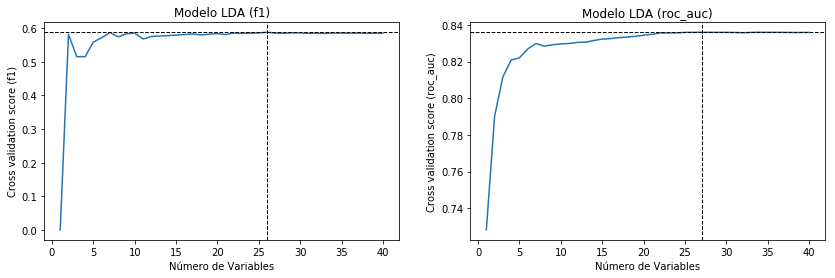

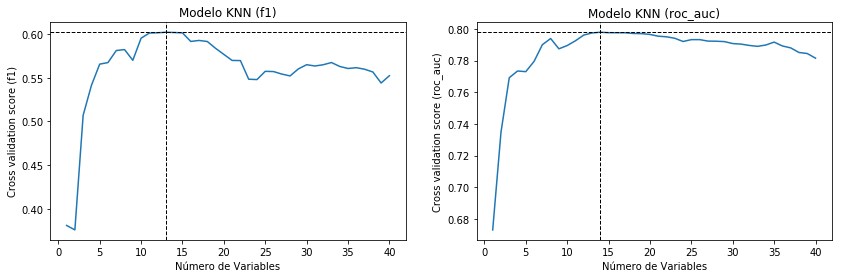

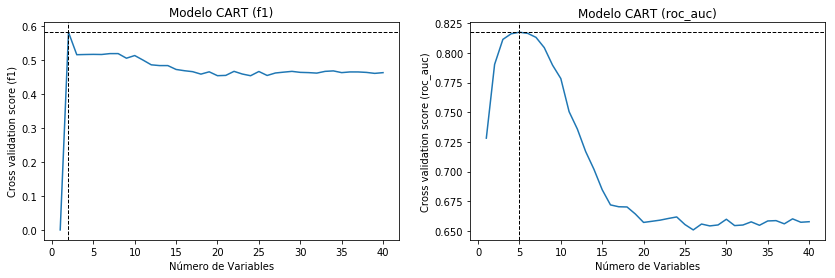

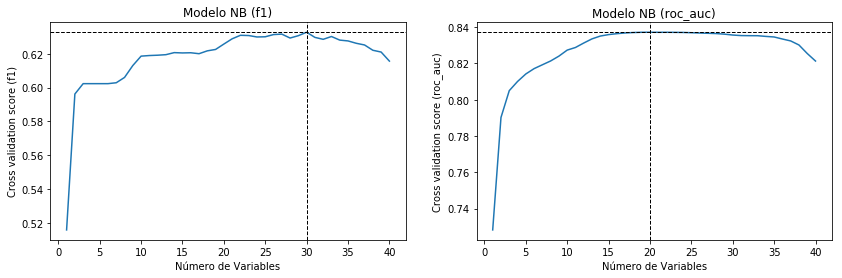

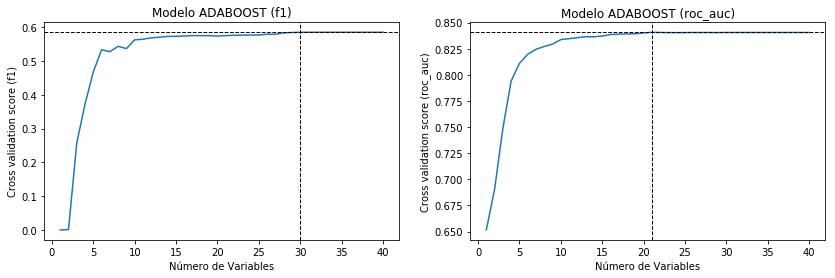

In [40]:
for name, model in models_binary_features.items():
  paintFeaturesSelection(model, name)

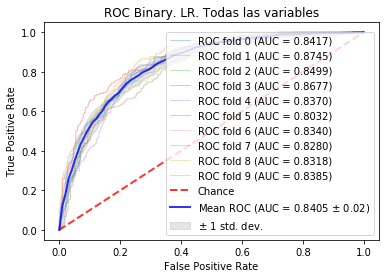

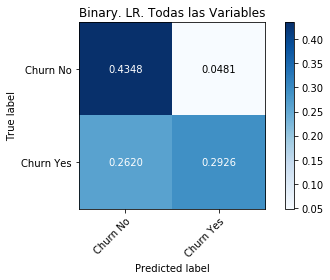

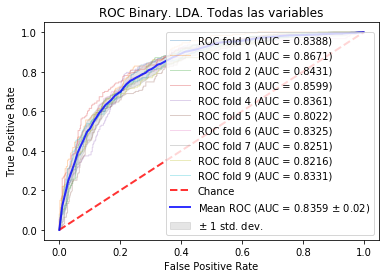

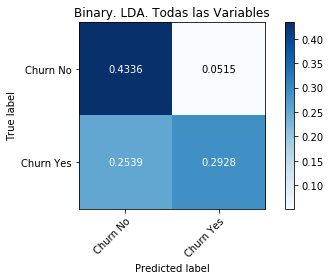

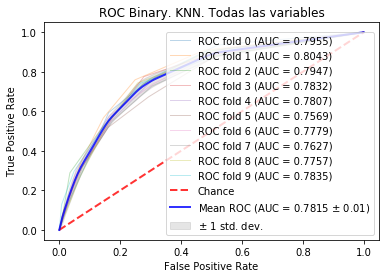

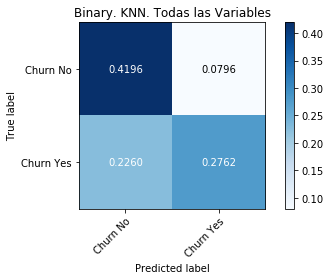

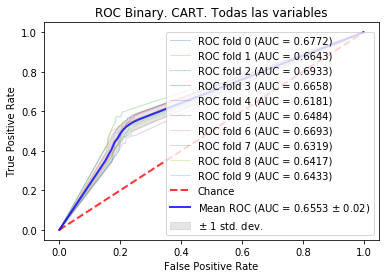

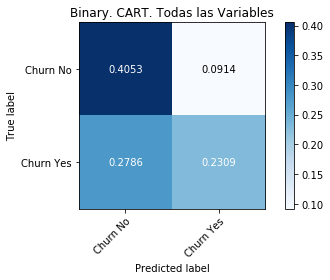

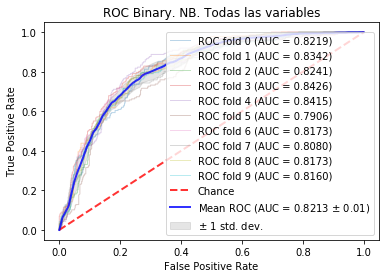

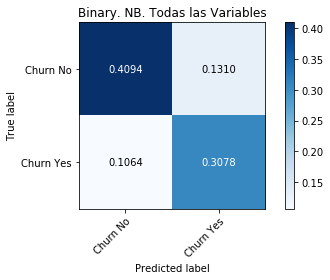

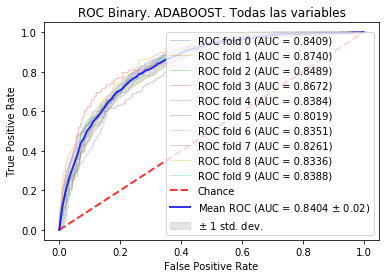

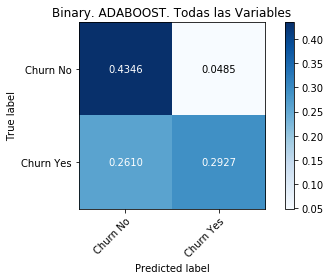

In [97]:
models_binary_metrics = {'all':{}, 'filter':{}}
for name, model in models.items():
  models_binary_metrics['all'][name] = paintROCCurve(X_binary, y_binary, model, 'ROC Binary. ' + name + '. Todas las variables')
  dfParams = pd.concat([dfParams, createParamsDataFrame(models_binary_metrics['all'][name], name, 'Binary', 'Todas Variables', '')])
  paintConfusionMatrix(models_binary_metrics['all'][name], normalize=True, title='Binary. ' + name + '. Todas las Variables')


['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer ', 'PaymentMethod_Credit card ', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure_bin_1', 'tenure_bin_2', 'tenure_bin_3', 'MonthlyCharges_bin_1', 'MonthlyCharges_bin_2', 'MonthlyCharges_bin_3', 'TheoMonthlyCharges_bin_1', 'TheoMonthlyCharges_bin_2', 'TheoMonthlyCharges_bin_3', 'TotalCharges_bin_1', 'TotalCharges_bin_2', 'TotalCharges_bin_3', 'DiffCharges_bin_1', 'DiffCharges_bin_2', 'DiffCharges_bin_3', 'DiffCharges_bin_4', 'DiffCharges_bin_5']


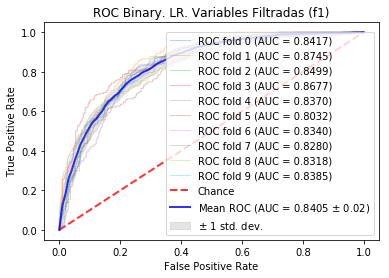

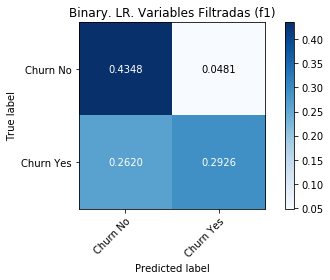

['SeniorCitizen', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer ', 'PaymentMethod_Credit card ', 'PaymentMethod_Mailed check', 'tenure_bin_1', 'tenure_bin_2', 'tenure_bin_3', 'MonthlyCharges_bin_2', 'MonthlyCharges_bin_3', 'TheoMonthlyCharges_bin_1', 'TheoMonthlyCharges_bin_2', 'TheoMonthlyCharges_bin_3', 'TotalCharges_bin_1', 'TotalCharges_bin_2', 'DiffCharges_bin_3']


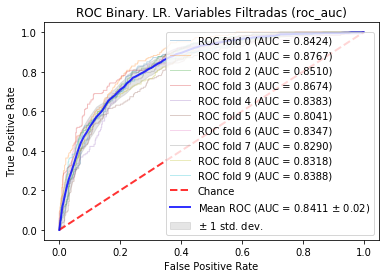

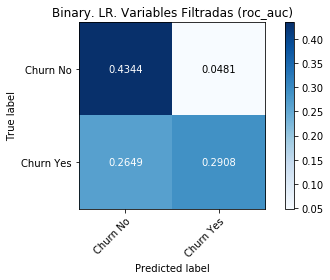

['SeniorCitizen', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Electronic check', 'tenure_bin_1', 'tenure_bin_2', 'tenure_bin_3', 'MonthlyCharges_bin_1', 'TheoMonthlyCharges_bin_1', 'TheoMonthlyCharges_bin_2', 'TheoMonthlyCharges_bin_3', 'TotalCharges_bin_1', 'TotalCharges_bin_3', 'DiffCharges_bin_3']


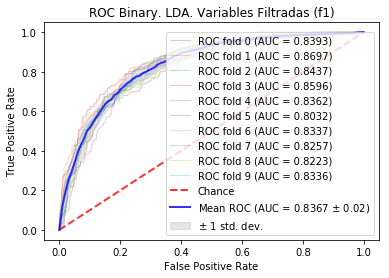

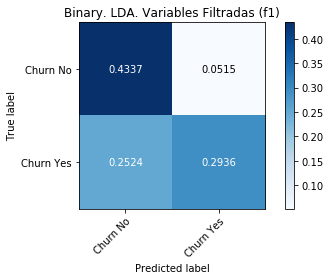

['SeniorCitizen', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card ', 'PaymentMethod_Electronic check', 'tenure_bin_1', 'tenure_bin_2', 'tenure_bin_3', 'MonthlyCharges_bin_1', 'TheoMonthlyCharges_bin_1', 'TheoMonthlyCharges_bin_2', 'TheoMonthlyCharges_bin_3', 'TotalCharges_bin_1', 'TotalCharges_bin_3', 'DiffCharges_bin_3']


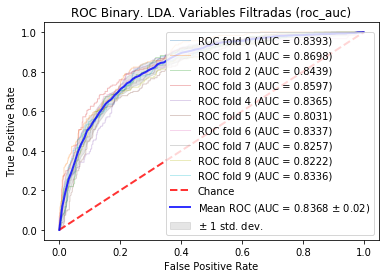

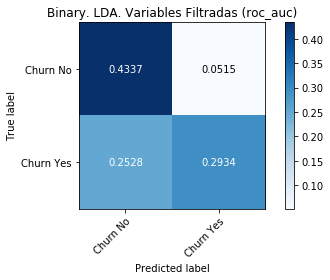

['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'MonthlyCharges_bin_1', 'PaperlessBilling', 'PaymentMethod_Credit card ', 'TheoMonthlyCharges_bin_1', 'TheoMonthlyCharges_bin_3', 'tenure_bin_1', 'tenure_bin_2']


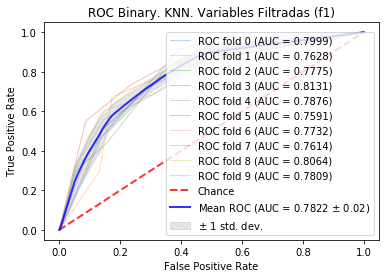

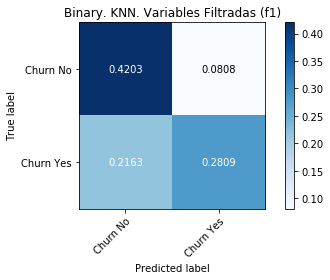

['Contract_Month-to-month', 'Contract_One year', 'InternetService_DSL', 'InternetService_Fiber optic', 'MonthlyCharges_bin_3', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'PhoneService', 'SeniorCitizen', 'StreamingTV', 'TechSupport', 'TheoMonthlyCharges_bin_2', 'tenure_bin_1', 'tenure_bin_3']


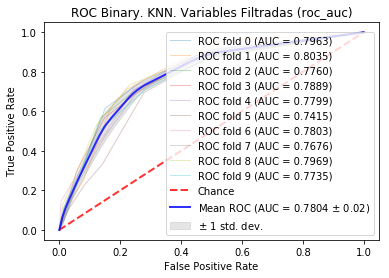

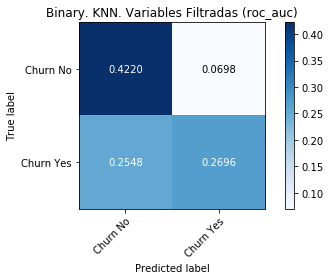

['InternetService_Fiber optic', 'Contract_Month-to-month']


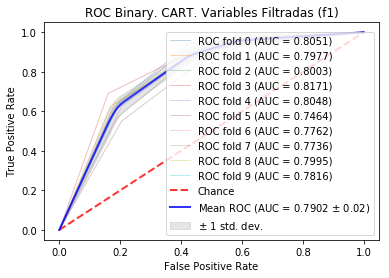

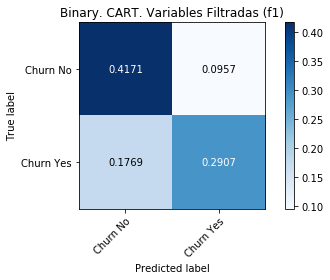

['gender', 'OnlineSecurity', 'InternetService_Fiber optic', 'Contract_Month-to-month', 'tenure_bin_1']


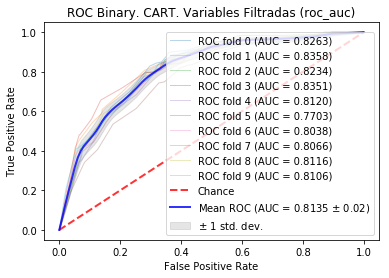

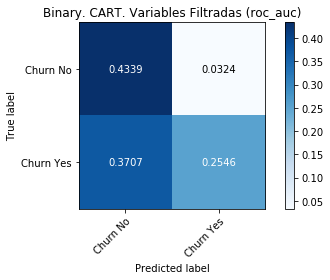

['Contract_Month-to-month', 'Contract_One year', 'DeviceProtection', 'DiffCharges_bin_2', 'DiffCharges_bin_3', 'DiffCharges_bin_4', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'MonthlyCharges_bin_2', 'MonthlyCharges_bin_3', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling', 'Partner', 'PaymentMethod_Bank transfer ', 'PaymentMethod_Credit card ', 'PaymentMethod_Mailed check', 'PhoneService', 'SeniorCitizen', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'TheoMonthlyCharges_bin_3', 'TotalCharges_bin_2', 'gender', 'tenure_bin_1', 'tenure_bin_2', 'tenure_bin_3']


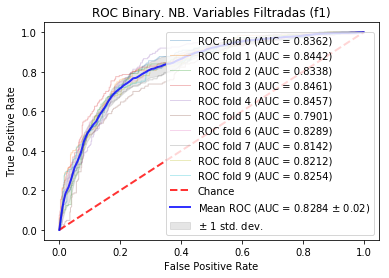

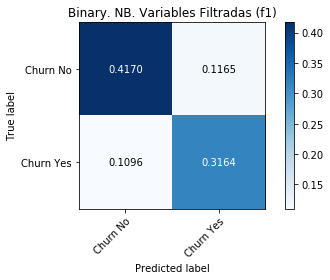

['Contract_Month-to-month', 'Contract_Two year', 'Dependents', 'DiffCharges_bin_4', 'InternetService_Fiber optic', 'InternetService_No', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling', 'PaymentMethod_Electronic check', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'TheoMonthlyCharges_bin_2', 'TheoMonthlyCharges_bin_3', 'TotalCharges_bin_1', 'tenure_bin_1', 'tenure_bin_2', 'tenure_bin_3']


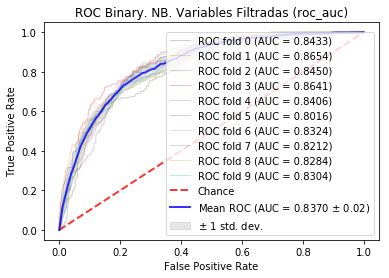

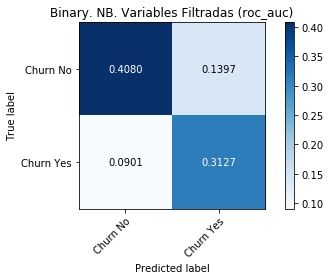

['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'PaymentMethod_Credit card ', 'PaymentMethod_Electronic check', 'tenure_bin_1', 'tenure_bin_3', 'MonthlyCharges_bin_1', 'MonthlyCharges_bin_2', 'MonthlyCharges_bin_3', 'TheoMonthlyCharges_bin_1', 'TotalCharges_bin_1', 'TotalCharges_bin_2', 'DiffCharges_bin_1', 'DiffCharges_bin_3', 'DiffCharges_bin_4']


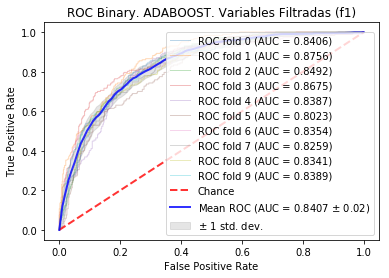

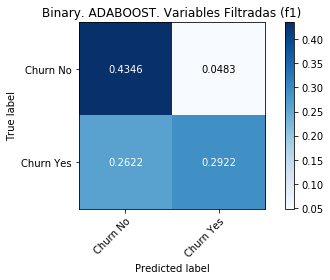

['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'InternetService_DSL', 'InternetService_Fiber optic', 'Contract_Month-to-month', 'Contract_One year', 'PaymentMethod_Electronic check', 'tenure_bin_1', 'tenure_bin_3', 'TheoMonthlyCharges_bin_1', 'TotalCharges_bin_1', 'DiffCharges_bin_1', 'DiffCharges_bin_3', 'DiffCharges_bin_4']


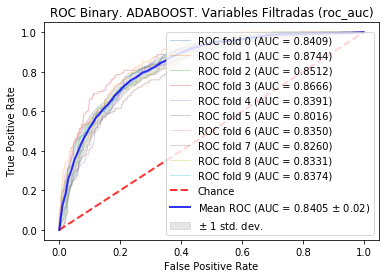

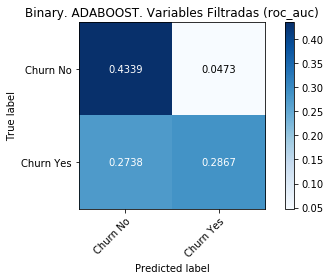

In [98]:
for name, model in models.items():
  for scoring in models_binary_features[name]:
    features_filter = models_binary_features[name][scoring]['in']
    print(features_filter)
    models_binary_metrics['filter'][name] = paintROCCurve(X_binary[features_filter], y_binary, model, 'ROC Binary. ' + name + '. Variables Filtradas (' + scoring +')')
    dfParams = pd.concat([dfParams, createParamsDataFrame(models_binary_metrics['filter'][name], name, 'Binary', 'Variables Filtradas (' + scoring +')', '')])
    paintConfusionMatrix(models_binary_metrics['filter'][name], normalize=True, title='Binary. ' + name + '. Variables Filtradas (' + scoring +')')


Podemos concluir que los ratios mejoran si se utilizan sólos las variables más importantes para cada modelo y dependiendo de la métrica a utilizar un LabelEncoding funciona mejor que un BinaryEncoding:

*   Regresión Logística o AdaBoost funcionan mejor con Label Encoding.
*   GaussianNB o KNN funcionan mejor con Binary Encoding.

Sin embargo la relación entre los TP y los FP es muy pareja en todos ellos, casi del 50%, exceptuando **KNN y NB** que consiguen ratios muy bueno en TP.

Parece todo apuntar a que seguramente se lancen dos o más modelados; quizás, un primer modelo que mejor prediga los TN y en caso de posible probabilidad alta de "no acierto", usar un segundo modelo que mejor prediga los TP. O quizás, utilizando técnicas como **Ensemble** para combinar aquellos mejores modelos.


#### WOE Features

Tal y como vimos, utilizar **IV** nos permitía quedarnos sólo con aquellas variables más interesantes. Según hemos visto, utilizando la técnica RFE, aparecen muchas más variables, incluso algunas que habían quedado descartadas por IV. Haremos dos estudios:


*   Nos quedaremos sólo con aquellas tipificadas como Strong y por Medium.
*   Añadiremos aquellas tipificadas como Strong y Medium.

En ambos casos, usaremos el dataset convertido con LabelEncoding.



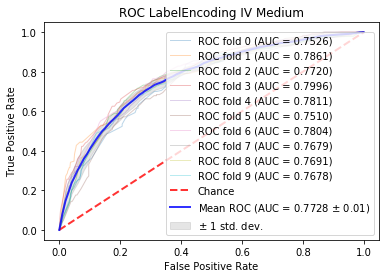

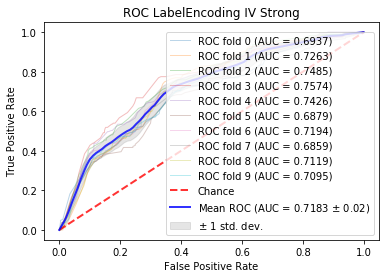

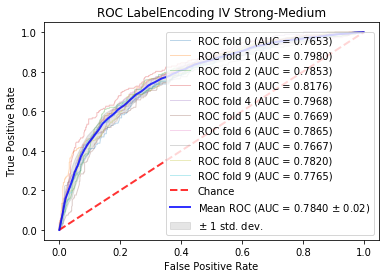

In [0]:
#list_features = combinatoria(['Strong', 'Suspicious', 'Medium', 'Useless', 'Weak'])
list_features = combinatoria(['Strong', 'Medium'])

for features_type in list_features:
  if features_type:
    features_woe = IV.loc[IV['Power'].isin(features_type)]['VAR_NAME'].tolist()
    paintROCCurve(X_labelencode[features_woe], y_labelencode, models['LR'], 'ROC LabelEncoding. LR IV ' + '-'.join(features_type))


Podemos deducir que, aunque IV parece una muy buena técnica para descubrir las mejores variables, sin duda RFE consigue mejores resultados.

#### OverSampling / UnderSampling

Dado el desbalanceo existente en el DataSet, utilizaremos técnicas para equilibrarlo. Dentro la suite de Python, hay varias opciones:

*   SMOTE, ADASYN, RandomUnderSampler para OverSampling (Amplia el número de registros de la clase minoritaria (**Churn No**).
*   RandomUnderSampler, NearMiss para UnderSampling (Reduce muestras de la clase mayoritaria (**Churn YES**).

Algo importante a tener en cuenta en éstas técnicas, sobre todo, over sampling, es dónde aplicarlo, máximo cuando se está utilizando cross-validation. Hay mucha literatura al respecto y parece ser un gran error aplicar over sampling al dataset y posteriormente, aplicar las técnicas de cross-validation. Algo que parece obvio pero hay muchos **post** en los que no se cuida que la parte de **test** debe ser lo más verídica posible. En pocos, se habla del concepto de **overoptimism**; básicamente, se traduce en que un entrenamiento con oversampling, se mejora el scoring si se usa como **test**, datos que han pasado, también, por una técnica de oversampling.

En consecuencia, aunque más lento, lo correcto usando cross-validation sería:

*   Hacer split (por ejemplo, con K-Fold).
*   Aplicar oversampling sólo a la parte de train dejando la parte de test tal cual.



In [99]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN 

samplers = []
samplers.append(('RandomOverSampler', RandomOverSampler(random_state=4313)))
samplers.append(('SMOTE', SMOTE(random_state=4313)))
samplers.append(('ADASYN', ADASYN(random_state=4313)))
samplers.append(('RandomUnderSampler', RandomUnderSampler(random_state=4313)))
samplers.append(('NearMiss', NearMiss(random_state=4313)))
samplers.append(('SMOTEENN', SMOTEENN(random_state=4313)))

models_features = {'LabelEncoding': models_label_features, 'Binary': models_binary_features}
for key_dataset, model_dataset in models_features.items():
  for name_sampler, sampler in samplers:
    for name_model, model in models.items():
      for scoring in model_dataset[name]:
        features_filter = model_dataset[name][scoring]['in']
        print(features_filter)
        if key_dataset == 'LabelEncoding':
          metrics = paintROCCurve(X_labelencode[features_filter], y_labelencode, model, 'ROC ' + key_dataset + '. ' + name_model + '. Variables Filtradas (' + scoring +') ' + name_sampler, sampler)
        else:
          metrics = paintROCCurve(X_binary[features_filter], y_binary, model, 'ROC ' + key_dataset + '. ' + name_model + '. Variables Filtradas (' + scoring +') ' + name_sampler, sampler)
        dfParams = pd.concat([dfParams, createParamsDataFrame(metrics, name_model, key_dataset, 'Variables Filtradas (' + scoring +')', name_sampler)])
        paintConfusionMatrix(metrics, normalize=True, title='' + key_dataset + '. ' + name_model + '. Variables Filtradas (' + scoring +') ' + name_sampler)


Output hidden; open in https://colab.research.google.com to view.

Vemos que éstas técnicas mejoran los parámetros; y dependiendo del modelo, unos **samplers** son mejores. Por ejemplo:


*   AdaBoost. f1 mejora usando **SMOTE** pero roc_auc no mejora con ningún sampler.
*   Decission Tree. f1 mejora usando **SMOTEENN** así como roc_auc.

Sin embargo, haciendo comparativa global, éstas mejoras no superan a otros modelos.



#### Hyper Parámetros

Otra "arma" que nos queda para mejorar el modelo es "jugar" con los hiper parámetros. Python posees dos herramientas **GridSearch** y **RandomSearch** para, a partir de una variedad de valores, quedarse con el mejor valor de cada uno de los hiper parámetros.

Sin embargo, se me ha hecho muy tedioso trabajar con los distintos hiper parámetros, máximo porque algunos dependen de otros; por ejemplo, en regresión logística hay muchos parámetros que sólo son válidos con **penalty=L2**. 

Por otro lado, hay ciertos parámetros numéricos en los que es necesario definir un rango de valores, por ejemplo, el parámetro C de Regresión Logística. Esto obliga a un primer estudio desde valores muy pequeños hasta valores muy grandes (0.01, 1, 10, 100) y luego ir afinando hasta llegar a un rango válido.

Por ésta razón, sólo he "jugado" con Regresión Logística y parece que tanto **C** como **penalty** son los que más afectan al modelo. 

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
#solver 'liblinear'
hyperparameters = {
  'penalty': ['l1', 'l2'], 
  'C': uniform(loc=40, scale=5)
}
       

randomCV = RandomizedSearchCV(LogisticRegression(), param_distributions=hyperparameters, cv=20, scoring='roc_auc', n_jobs=-1)  
randomCV.fit(X_labelencode[models_label_features['LR'][scoring]['in']], y_labelencode)

C_optim = randomCV.best_params_['C']
penalty_optim = randomCV.best_params_['penalty']

randomCV.best_params_


{'C': 41.88193343632493, 'penalty': 'l1'}

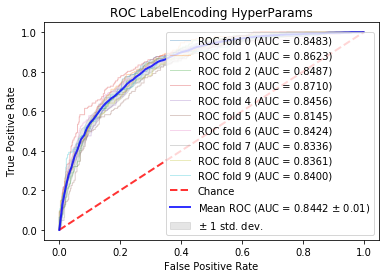

In [45]:
model_tuning = LogisticRegression(C=C_optim, penalty=penalty_optim)

model_tuning.get_params()

params_label_tuning = paintROCCurve(X_labelencode[models_label_features['LR']['f1']['in']], y_labelencode, model_tuning, 'ROC LabelEncoding HyperParams') 

In [0]:
dfParams = pd.concat([dfParams, createParamsDataFrame(params_label_tuning, 'LR', 'LabelEncoding', 'Variables Filtradas (f1)', 'HyperParams')])

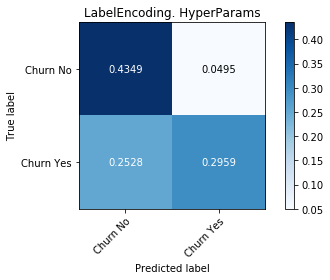

In [46]:
paintConfusionMatrix(params_label_tuning, normalize=True, title='LabelEncoding. HyperParams') 

In [0]:
dfAgg = dfParams.groupby(['model', 'dataset', 'variables', 'sampler']).agg({
    'duration':[('max_duration', 'max'), ('min_duration', 'min'), ('mean_duration', 'mean')], 
    'f1_test':[('max_f1_test', 'max'), ('min_f1_test', 'min'), ('mean_f1_test', 'mean')], 
    'f1_train':[('max_f1_train', 'max'), ('min_f1_train', 'min'), ('mean_f1_train', 'mean')], 
    'roc_auc':[('max_roc_auc', 'max'), ('min_roc_auc', 'min'), ('mean_roc_auc', 'mean')],
    'TP':[('TP', 'mean')],
    'TN':[('TN', 'mean')],
    'FP':[('FP', 'mean')],
    'FN':[('FN', 'mean')],
    'cv':[('folds', 'count')]
}).reset_index()
dfAgg.columns = [b if b!="" else a for a, b in dfAgg.columns]
dfAgg['name'] = dfAgg[['model', 'dataset', 'variables', 'sampler']].apply(lambda x: ' '.join(x), axis=1)
dfAgg.to_csv("models.csv", sep=";", decimal=",", index=False)

dfParams.to_csv("models_cv.csv", sep=";", decimal=",", index=False)


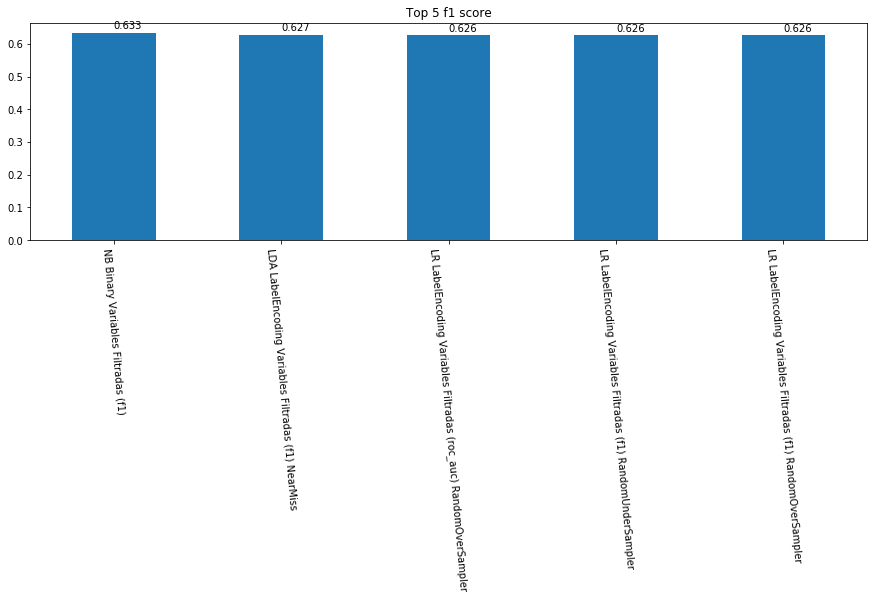

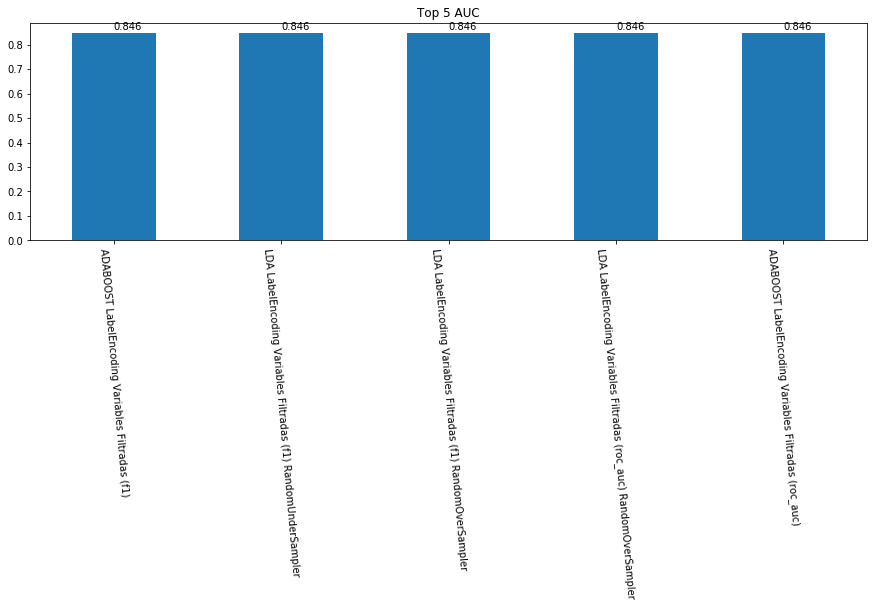

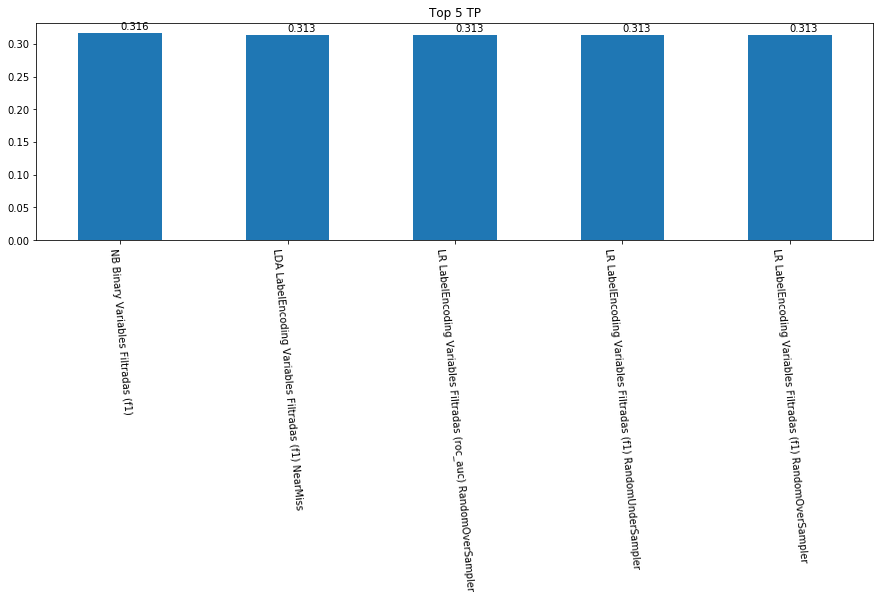

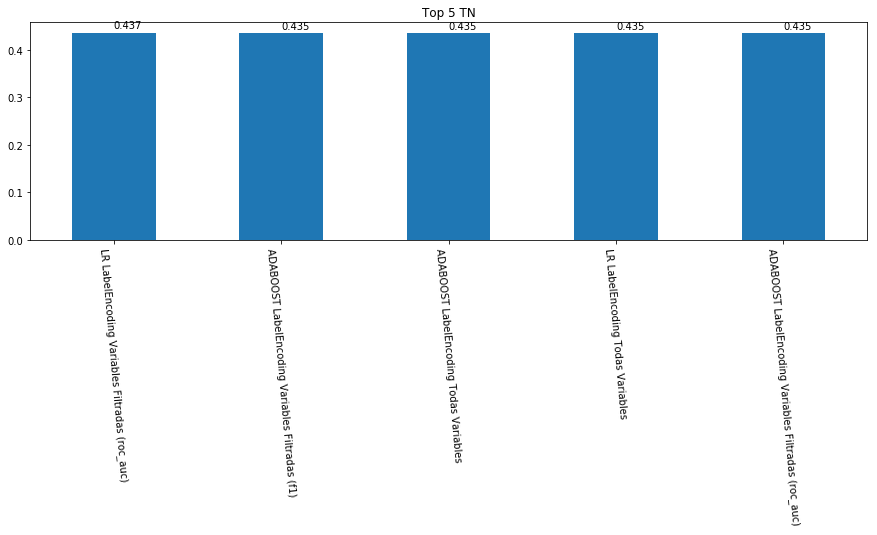

In [101]:
for field_key, field_limit in {'mean_f1_test': 0.625, 'mean_roc_auc': 0.846, 'TP': 0.313, 'TN': 0.4}.items():
  fig, ax = plt.subplots(figsize=(15, 4))
  if field_key in ['FP', 'FN']:
    dfShow = dfAgg.sort_values(field_key, ascending=True).head(5)
  else:
    dfShow = dfAgg.sort_values(field_key, ascending=False).head(5)
  ax = dfShow.plot.bar(x='name', y=field_key, rot=-85, ax=ax)
  if field_key=='mean_f1_test':
    title = "f1 score"
  elif field_key=='mean_roc_auc':
    title = "AUC"
  else:
    title = field_key 
  ax.set_title("Top 5 " + title)
  ax.set_xlabel("")
  ax.get_legend().remove()
  for idx, label in enumerate(list(dfShow.index)): 
    value = np.round(dfShow.iloc[idx][field_key], decimals=3)
    ax.annotate(value,
        (idx, value),
        xytext=(0, 4), 
        textcoords='offset points')
  plt.show()

In [102]:
indexes = []
for field in ['mean_duration','mean_f1_test', 'mean_roc_auc', 'TP', 'TN']:
  ascending = True if field in ['mean_duration', 'FP', 'FN'] else False
  print(ascending)
  model = dfAgg.sort_values(field, ascending=ascending).head(1)
  index, = model.index
  print(field, index)
  indexes.append(index)

print(indexes)
dfAgg.iloc[indexes][['model', 'dataset', 'variables', 'sampler']]

True
mean_duration 31
False
mean_f1_test 151
False
mean_roc_auc 16
False
TP 151
False
TN 143
[31, 151, 16, 151, 143]


model        dataset                      variables sampler
31       CART         Binary       Variables Filtradas (f1)        
151        NB         Binary       Variables Filtradas (f1)        
16   ADABOOST  LabelEncoding       Variables Filtradas (f1)        
151        NB         Binary       Variables Filtradas (f1)        
143        LR  LabelEncoding  Variables Filtradas (roc_auc)

#### Selección de Modelo

Dependiendo de la métrica que se quiera optimizar (en nuestro caso, hemos utilizado **roc_auc** y **f1_score**), unos modelos tienen mejores resultados que otros; sin embargo llama la atención que la relación entre los TP y los FN sea muy pareja, algo que hace, prácticamente, "tirar una moneda al aire" para predecir los clientes Churn. Así pues, parece que una buena opción sería quedarse con los mejores que predigan los TP y los TN. 

Dada la casuística a predecir, no nos podemos quedar con un único modelo, máximo porque lo que nos interesa es predecir los TP y, quizás, igual de importante, tener muy controlados, los FN. Nos interesa saber qué cliente (TP) se va pero también, qué cliente, supuestamente, se queda, pero, realmente, se va (FN). De forma unitaria, podemos ver que los mejores modelos son:   

*   Mejor **f1_score**  => NB. Binary. Variables Filtradas (f1)
*   Mejor **roc_auc** => ADABOOST. LabelEncoding. Variables Filtradas (f1)
*   Mejor **TP** => NB. Binary. Variables Filtradas (f1)
*   Mejor **TN** => LR.	LabelEncoding.	Variables Filtradas (roc_auc)	

La matriz de confusión proporciona **un arma muy potente** para decidir qué modelo/s es/son los más interesantes y dado que, ningún modelo tiene lo mejor de todos los mundos (la mayoría predicen muy bien los TN pero predicen muy mal los TP o al menos, su relación con los FN es muy similar), parece que es necesario introducir una lógica añadida. Por ello, si tuviera que montarlo en un entorno productivo, me decantaría por disponer de varios modelos y con secuencias **if else** utilizar uno u otro. Aproximadamente, la secuencia sería:

1.   Usar el algoritmo que mejor TN/FP proporcione.
2.   Si la probabilidad de predicción TN de ese cliente es buena => Etiquetarlo como Churn=No.
3.   Si la probabilidad de predicción TN de ese cliente es mala => Utilizar el algoritmo que mejor TP/FN proporcione.
4.   Si la probabilidad de predicción TP de ese cliente es buena => Etiquetarlo como Churn=Yes.
5.   Si la probabilidad de predicción TP de ese cliente es mala => (ante la duda) Etiquetarlo como Churn=Yes.

Otra opción sería utilizar técnicas equivalentes a las que usa Random Forest, con **Ensemble**, quedarnos con los mejores algoritmos y por vía método de votación, ejecutar la predicción. Sin embargo, dada la disparidad existente entre los TN y los TP en los distintos algoritmos, casi parece más interesante ejecutar una secuencia más discriminatoria vía **if else**.



## Conclusiones

Podemos ver que un análisis exploratio nos da mucha información acerca de la importancia de las distintas variables. Sin embargo, llevado a algoritmia, en éste caso no podemos olvidar que ciertas variables, como **gender**, que a simple vista no parecen tener importancia, sí que pueden llegar a afectar al scoring. En ese sentido, haber "creído" a pies juntillas lo que **IV** decía, habría que hecho que no se consiguera el mejor modelo.

Dependiendo del modelo utilizado, **Label Encoding** consigue mejores resultados frente a **One Hot Encoding**; así mismo, cada modelo tiene preferencia por ciertas variables.

La creación de variables extras es todo un arte, y en este caso, hemos tenido **suerte** al calcular **DiffCharges** como resta de la cuota mensual y la media de las cuotas mensuales (TotalCharges/tenure) ya que es una variable muy interesante; no sólo porque afecta al modelo sino también, porque su distribución obedece a una distribución normal, algo que siempre parece ser interesante en éste tipo de modelos.

De las técnicas para reducir el des balanceo, cada modelo mejora una específica aunque esa mejora nunca llega a superar a otros modelos.

Hacer tuning de los hiper parámetros hace que pueda mejorar el modelo, sin embargo, si no fuera por herramientas como GridSearch o RandomSearch, sería una tarea muy laboriosa, ya que es necesario realizar algún tipo de **código** que mezcle toda la combinatoria de todos los parámetros e itere sobre ellos quedándose con el mejor.
      
Parece que existe una relación entre las distintas técnicas y el orden de ejecución puede cambiar las **cosas** de forma radical. Así, por ejemplo, la optimización de hyper parámetros y la selección de variables están muy relacionados entre sí. Así mismo, añadir o eliminar más registros al DataSet, hace, también, que el total de variables seleccionadas o los hyper parámetros, también, cambien. Esto me genera muchas dudas sobre **mejores prácticas** a la hora de utilizar una técnica u otra y el orden de ejecución. En el proyecto, hemos seguido una secuencia de:

1.   Selección de métricas para optimizar en el Cross Validation.
2.   Selección de variables basadas en esas métricas.
3.   Tuning del DataSet para intentar mejorar esas métricas (OverSampling, UnderSampling).
4.   Tuning del Modelo para intentar mejorar esas métricas (RandomSearch)

Pero, ¿es esta la mejor secuencia teniendo en cuenta que lo que queremos es predecir el mayor número de TP? O quizás, más importante, que el número de FN sea el mínimo posible. 

En ambos trabajos, tanto el individual como el grupal, al tener que realizar tanta prueba y error, disponer de un **framework** de desarrollo interesante es vital. En definitiva, disponer de un conjunto de funciones que vía parámetro, se personalicen los datos a mostrar, el modelo a probar, etc.. Sin esas funciones, hubiera sido mucho más tedioso realizar distintas pruebas y tanta combinatoria de elementos. Al final, debe haber un equilibrio entre **fuerza bruta** equivalente a optiML y cierto **arte y ensayo**, y por qué no, **suerte** para conseguir el mejor modelo (o conjunto de modelos) o esa variable que hace que lo cambie todo.
